0.5914797262961665 0.5914797262961667


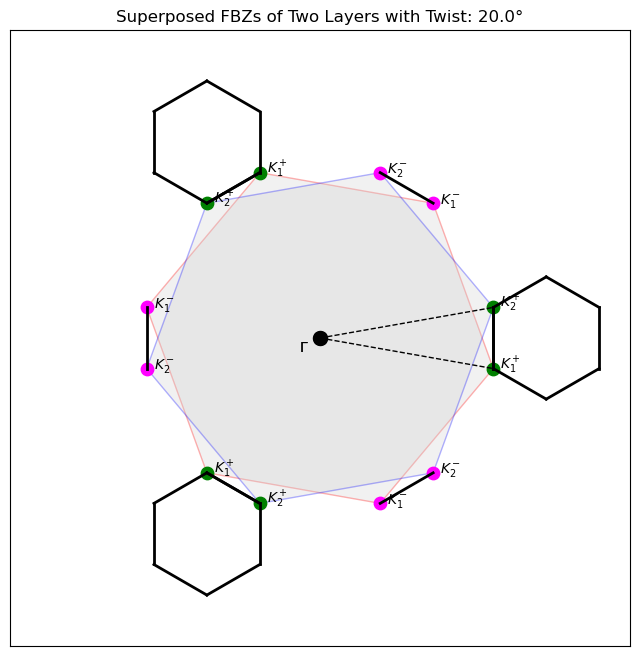

In [173]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import Voronoi, ConvexHull
from scipy.spatial.distance import cdist

"""PART 1: PLOT ROTATED FBZ AND FORMATION OF MBZ"""


# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

# Rotation matrix function
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])


# Function to plot the FBZ for both layers in a single plot
def plot_fbz_superposed(b, theta1, theta2,K1_plus, K2_plus):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.title(f'Superposed FBZs of Two Layers with Twist: {(theta2 - theta1)*(180/np.pi)}°')

    # Layer 1 FBZ (Rotated by theta1)
    K_vertices1, K_prime_vertices1 = plot_fbz_layer(b, theta1, layer=1, color='red', ax=ax, K_plus_label='$K_1^+$', K_minus_label="$K_1^-$")

    # Layer 2 FBZ (Rotated by theta2)
    K_vertices2, K_prime_vertices2 = plot_fbz_layer(b, theta2, layer=2, color='blue', ax=ax, K_plus_label='$K_2^+$', K_minus_label="$K_2^-$")

    # Find the closest pair of adjacent K+ points between the two layers
    distances = cdist(K_vertices1, K_vertices2)  # Compute pairwise distances
    min_distance_idx = np.unravel_index(np.argmin(distances), distances.shape)
    closest_K1 = K_vertices1[0]
    closest_K2 = K_vertices2[1]


    
    # Plot dashed line from Gamma to the closest pair of K+ points of both layers
    Gamma = np.array([0, 0])
    ax.plot([Gamma[0], closest_K1[0]], [Gamma[1], closest_K1[1]], 'k--', lw=1)  # Line to K1+
    ax.plot([Gamma[0], closest_K2[0]], [Gamma[1], closest_K2[1]], 'k--', lw=1)  # Line to K2+

    
    
    # Draw solid lines between adjacent K+ and K- points for both layers
    i = 0
    for K1, K2 in zip(K_vertices1, K_vertices2):
        K2 = K_vertices2[(i + 1) % len(K_vertices2)] # access next element of array rather than standard first element (with wrap around)
        ax.plot([K1[0], K2[0]], [K1[1], K2[1]], 'k-', lw=2)  # Solid line between adjacent K+ points
        i = i + 1
    i = 0
    for K_prime1, K_prime2 in zip(K_prime_vertices1, K_prime_vertices2):
        K_prime2 = K_prime_vertices2[(i + 1) % len(K_vertices2)]
        ax.plot([K_prime1[0], K_prime2[0]], [K_prime1[1], K_prime2[1]], 'k-', lw=2)  # Solid line between adjacent K- points
        i = i + 1



    """ PLOT MOIRE BZ Across Pairs of K-Valleys"""
    def rotate_around_point(point, origin, angle_rad):
        translation = point - origin
        rotated_translation = np.dot(rotation_matrix(angle_rad), translation)
        return rotated_translation + origin

    ax.plot([K1_plus[0], K2_plus[0]], [K1_plus[1], K2_plus[1]], 'k-', lw=2, label="Original Line")
    rotated_K1_120 = rotate_around_point(K1_plus, np.array([0,0]), np.radians(120))
    rotated_K2_120 = rotate_around_point(K2_plus, np.array([0,0]), np.radians(120))
    rotated_K1_240 = rotate_around_point(K1_plus, np.array([0,0]), np.radians(240))
    rotated_K2_240 = rotate_around_point(K2_plus, np.array([0,0]), np.radians(240))

    ax.plot([rotated_K1_120[0], rotated_K2_120[0]], [rotated_K1_120[1], rotated_K2_120[1]], 'k-', lw=2)
    ax.plot([rotated_K1_240[0], rotated_K2_240[0]], [rotated_K1_240[1], rotated_K2_240[1]], 'k-', lw=2)

    # Iteratively rotate and plot the new line segments
    current_K1 = K1_plus
    current_K1_120 = rotated_K1_120
    current_K1_240 = rotated_K2_120
    current_K2 = K2_plus
    current_K2_120 = rotated_K1_240
    current_K2_240 = rotated_K2_240
    
    for i in range(5):
        next_K1 = rotate_around_point(current_K2, current_K1, np.radians(-120))
        next_K2 = rotate_around_point(current_K1, current_K1, np.radians(-120))
        
        next_K1_120 = rotate_around_point(next_K1, np.array([0,0]), np.radians(120))
        next_K2_120 = rotate_around_point(next_K2 , np.array([0,0]), np.radians(120))
        next_K1_240 = rotate_around_point(next_K1, np.array([0,0]), np.radians(240))
        next_K2_240 = rotate_around_point(next_K2 , np.array([0,0]), np.radians(240))

        
        
        ax.plot([next_K1[0], next_K2[0]], [next_K1[1], next_K2[1]], 'k-', lw=2 )    
        ax.plot([next_K1_120[0], next_K2_120[0]], [next_K1_120[1], next_K2_120[1]], 'k-', lw=2)
        ax.plot([next_K1_240[0], next_K2_240[0]], [next_K1_240[1], next_K2_240[1]], 'k-', lw=2)


        # Update for next iteration
        current_K1 = next_K1
        current_K2 = next_K2

    



    plt.axis('equal')
    plt.xlim([-3.0, 3.0])
    plt.ylim([-3.0, 3.0])
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Helper function to plot a single layer's FBZ on the given axes
def plot_fbz_layer(b, theta, layer, color, ax, K_plus_label='$K_{{{}}}^+$', K_minus_label="$K_{{{}}}^-$"):
    rotation = rotation_matrix(theta)
    b_rotated = np.dot(b, rotation.T)

    # Generate reciprocal lattice points
    N = 1  # Include immediate neighbors
    reciprocal_lattice_points = []
    b1, b2 = b_rotated[0], b_rotated[1]
    for n in range(-N, N + 1):
        for m in range(-N, N + 1):
            K_point = n * b1 + m * b2
            reciprocal_lattice_points.append(K_point)
    reciprocal_lattice_points = np.array(reciprocal_lattice_points)

    # Create Voronoi diagram to find the FBZ
    vor = Voronoi(reciprocal_lattice_points)

    # Identify the region corresponding to the origin (Gamma point)
    center_indices = np.where(np.all(np.isclose(reciprocal_lattice_points, [0, 0], atol=1e-8), axis=1))[0]
    center_index = center_indices[0]
    center_region_index = vor.point_region[center_index]
    center_region = vor.regions[center_region_index]

    # Get the vertices of the FBZ
    vertices = vor.vertices[center_region]

    # Order the vertices counter-clockwise
    hull = ConvexHull(vertices)
    vertices = vertices[hull.vertices]

    # High-symmetry points
    Gamma = np.array([0, 0])

    # Compute the K and K' points explicitly
    K_point = (2 * b_rotated[0] + b_rotated[1]) / 3
    K_prime_point = -K_point  # Inversion through Gamma point

    # Identify the K and K' points among the vertices
    K_vertices = []
    K_prime_vertices = []
    for vertex in vertices:
        matched = False
        for n in [-1, 0, 1]:
            for m in [-1, 0, 1]:
                shift = n * b_rotated[0] + m * b_rotated[1]
                if np.allclose(vertex, K_point + shift, atol=1e-8):
                    K_vertices.append(vertex)
                    matched = True
                    break
                elif np.allclose(vertex, K_prime_point + shift, atol=1e-8):
                    K_prime_vertices.append(vertex)
                    matched = True
                    break
            if matched:
                break

    # Plot the FBZ polygon
    polygon = Polygon(vertices, closed=True, facecolor='lightgray', edgecolor=color, alpha=0.3)
    ax.add_patch(polygon)

    # Mark and label the Gamma point
    ax.scatter(Gamma[0], Gamma[1], color='black', s=100)
    ax.annotate('$\\Gamma$', xy=(Gamma[0], Gamma[1]), xytext=(-15, -10), textcoords='offset points')

    # Label K points
    for K in K_vertices:
        ax.scatter(K[0], K[1], color='green', s=80)
        ax.annotate(K_plus_label.format(layer), xy=(K[0], K[1]), xytext=(5, 0), textcoords='offset points')

    # Label K' points
    for K_prime in K_prime_vertices:
        ax.scatter(K_prime[0], K_prime[1], color='magenta', s=80)
        ax.annotate(K_minus_label.format(layer), xy=(K_prime[0], K_prime[1]), xytext=(5, 0), textcoords='offset points')

    
    


    return K_vertices, K_prime_vertices

# Main function
def main():

    # **Relevant Parameters**
    t = 2700  # Hopping parameter (meV) (Intralayer)
    w0 = 110  # AB hopping amplitude
    w1 = 65   # AA hopping amplitude
    
    # Carbon-carbon bond distance (Ångströms)
    a0 = 1.42
    # Lattice constant (Ångströms)
    d = a0 * np.sqrt(3)
    
    # Reciprocal lattice constant (1/Å)
    kD = 4 * np.pi / (3 * a0 * np.sqrt(3))
    
    a0 = 1.42  # Carbon-carbon bond distance (Ångströms)
    d = a0 * np.sqrt(3)  # Lattice constant
    a = np.array([
        [d, 0],
        d * np.array([0.5, np.sqrt(3)/2])
    ])

    # Get reciprocal lattice vectors
    b = get_reciprocal_lattice_vectors(a)

    # Set rotation angles
    theta = 20
    theta_rad = np.radians(theta)
    theta1 = np.radians(-theta / 2)  # Rotation for layer 1
    theta2 = np.radians(theta / 2)   # Rotation for layer 2


    # Rotation of Reciprocal Lattice Vectors
    b1_rotated = np.dot(b, rotation_matrix(theta1).T)
    b2_rotated = np.dot(b, rotation_matrix(theta2).T)

    # Compute the K points from rotated reciprocal lattice vectors
    K1_plus = (2 * b1_rotated[0] + b1_rotated[1]) / 3
    K2_plus = (2 * b2_rotated[0] + b2_rotated[1]) / 3

    moire_bz_side_length = np.linalg.norm(K2_plus - K1_plus)
    expected_side_length = 2 * kD * np.sin(theta_rad / 2)


    print(moire_bz_side_length, expected_side_length)

    
    # Plot superposed FBZ for both layers
    plot_fbz_superposed(b, theta1, theta2,K1_plus, K2_plus)




main()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import rcParams
from scipy.spatial import Voronoi, ConvexHull
from scipy.ndimage import gaussian_filter1d
import ipywidgets as widgets
from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display

"""Part 2 - GRAPH OF MOIRE LATTICE"""


# Disable LaTeX rendering to avoid errors
rcParams['text.usetex'] = False

# **Relevant Parameters**
t = 2700  # Hopping parameter (meV) (Intralayer)
w0 = 110  # AB hopping amplitude
w1 = 65   # AA hopping amplitude

# Carbon-carbon bond distance (Ångströms)
a0 = 1.42

# Lattice constant (Ångströms)
d = a0 * np.sqrt(3)

# Reciprocal lattice constant (1/Å)
kD = 4 * np.pi / (3 * a0 * np.sqrt(3))

# **Lattice Vectors**
a = np.array([
    [d, 0],
    d * np.array([0.5, np.sqrt(3)/2])
])

# **Nearest Neighbor Vectors (Corrected)**
delta1 = -(1/3) * a[0] + (2/3) * a[1]
delta2 = (-1/3) * a[0] - (1/3) * a[1]
delta3 = (2/3) * a[0] - (1/3) * a[1]
delta = np.array([delta1, delta2, delta3])

# Define the function to calculate the reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    """
    Calculates the reciprocal lattice vectors for a 2D lattice.
    """
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return b1, b2

# Now calculate reciprocal lattice vectors
b1, b2 = get_reciprocal_lattice_vectors(a)

"""Functions"""
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
        ])

def generate_lattice_points(a, n_max, m_max, scale=1.0):
    """
    Generates positions of the atoms in sublattices A and B for the graphene lattice.
    Applies a scaling factor to shrink hexagons.
    
    Parameters:
    - a: Lattice vectors
    - n_max, m_max: Grid limits for lattice points
    - scale: Scaling factor to adjust hexagon size.
    """
    lattice_A = []
    lattice_B = []
    delta_shift = scale * (a[0] + a[1]) / 3

    for n in range(-n_max, n_max + 1):
        for m in range(-m_max, m_max + 1):
            R = scale * (n * a[0] + m * a[1])
            lattice_A.append(R)
            lattice_B.append(R + delta_shift)

    return np.array(lattice_A), np.array(lattice_B)

def plot_bilayer_lattice(theta_deg=1.05, lattice_extent=20, scale=0.5):
    """
    Plots the bilayer graphene lattice with rotated bonds.
    
    Parameters:
    - theta_deg: twist angle in degrees.
    - lattice_extent: the extent of the lattice to be shown.
    - scale: scaling factor for adjusting the hexagon size.
    """
    # Convert degrees to radians for rotation
    theta_rad = np.radians(theta_deg)
    rotation = rotation_matrix(theta_rad)
    
    # **Generate Lattice Points for Layer 1**
    n_max = 30  # Larger lattice grid
    m_max = 30
    lattice_A1, lattice_B1 = generate_lattice_points(a, n_max, m_max, scale)
    
    # Apply rotation to layer 2 positions and bonds
    lattice_A2 = np.dot(lattice_A1, rotation.T)
    lattice_B2 = np.dot(lattice_B1, rotation.T)
    delta_rotated = np.dot(delta, rotation.T)

    plt.figure(figsize=(12, 12))  # Increase figure size for a larger canvas
    plt.title(f'Bilayer Graphene (Twisted by {theta_deg}°) with Moiré Pattern')
    
    # Plot sublattice A and B for layer 1
    plt.scatter(lattice_A1[:, 0], lattice_A1[:, 1], color='blue', label='Sublattice A (Layer 1)', s=10)
    plt.scatter(lattice_B1[:, 0], lattice_B1[:, 1], color='red', label='Sublattice B (Layer 1)', s=10)

    # Plot sublattice A and B for layer 2 (rotated)
    plt.scatter(lattice_A2[:, 0], lattice_A2[:, 1], color='green', label='Sublattice A (Layer 2)', s=10)
    plt.scatter(lattice_B2[:, 0], lattice_B2[:, 1], color='orange', label='Sublattice B (Layer 2)', s=10)

    # Plot bonds between nearest neighbors for both layers
    for A_pos in lattice_A1:
        for d_vec in delta:
            B_pos = A_pos - d_vec  # Nearest neighbors in layer 1
            plt.plot([A_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], color='black', linewidth=0.5)

    for A_pos in lattice_A2:
        for d_vec in delta_rotated:  # Apply rotated delta for the second layer
            B_pos = A_pos - d_vec  # Nearest neighbors in layer 2
            plt.plot([A_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], color='black', linewidth=0.5)

    # Ensure equal aspect ratio and limits for a zoomed-in portion of the lattice
    plt.axis('equal')
    plt.xlim(-lattice_extent, lattice_extent)
    plt.ylim(-lattice_extent, lattice_extent)

    plt.xticks([])
    plt.yticks([])

    # Add legend
    plt.legend()
    plt.show()


# **Add interactive slider for twist angle**
interactive_plot = interact(plot_bilayer_lattice,
                            theta_deg=widgets.FloatSlider(min=0.1, max=5.0, step=0.05, value=1.05, description='Twist Angle'),.
                            lattice_extent=widgets.IntSlider(min=10, max=30, step=1, value=20, description='Lattice Extent'),
                            scale=widgets.FloatSlider(min=0.1, max=1.0, step=0.1, value=0.5, description='Scale'))


interactive(children=(FloatSlider(value=1.05, description='Twist Angle', max=5.0, min=0.1, step=0.05), IntSlid…

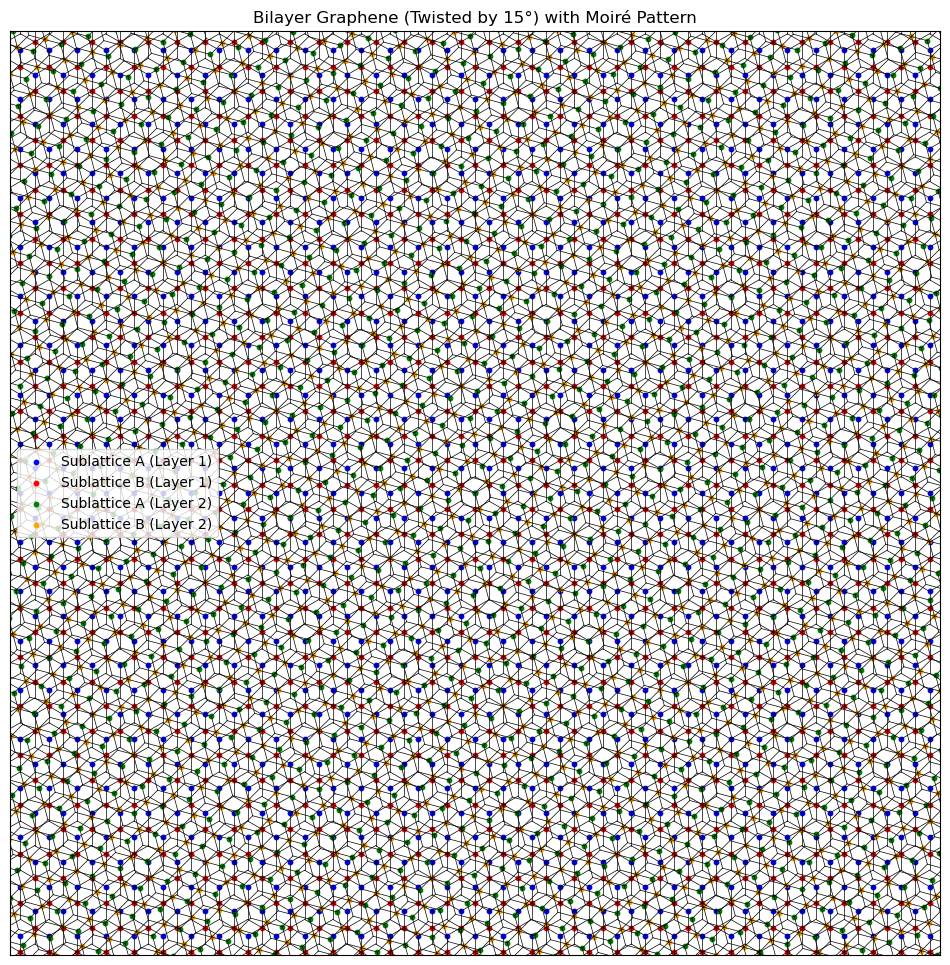

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import rcParams
from scipy.spatial import Voronoi, ConvexHull
from scipy.ndimage import gaussian_filter1d
"""ALTERNATIVE GRAPH OF MOIRE LATTICE"""

# Disable LaTeX rendering to avoid errors
rcParams['text.usetex'] = False

# **Relevant Parameters**
t = 2700  # Hopping parameter (meV) (Intralayer)
w0 = 110  # AB hopping amplitude
w1 = 65   # AA hopping amplitude

# Carbon-carbon bond distance (Ångströms)
a0 = 1.42

# Lattice constant (Ångströms)
d = a0 * np.sqrt(3)

# Reciprocal lattice constant (1/Å)
kD = 4 * np.pi / (3 * a0 * np.sqrt(3))

# **Lattice Vectors**
a = np.array([
    [d, 0],
    d * np.array([0.5, np.sqrt(3)/2])
])

# **Nearest Neighbor Vectors (Corrected)**
delta1 = -(1/3) * a[0] + (2/3) * a[1]
delta2 = (-1/3) * a[0] - (1/3) * a[1]
delta3 = (2/3) * a[0] - (1/3) * a[1]
delta = np.array([delta1, delta2, delta3])

# Define the function to calculate the reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    """
    Calculates the reciprocal lattice vectors for a 2D lattice.
    """
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return b1, b2

# Now calculate reciprocal lattice vectors
b1, b2 = get_reciprocal_lattice_vectors(a)

"""Functions"""
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
        ])

def generate_lattice_points(a, n_max, m_max, scale=1.0):
    """
    Generates positions of the atoms in sublattices A and B for the graphene lattice.
    Applies a scaling factor to shrink hexagons.
    
    Parameters:
    - a: Lattice vectors
    - n_max, m_max: Grid limits for lattice points
    - scale: Scaling factor to adjust hexagon size.
    """
    lattice_A = []
    lattice_B = []
    delta_shift = scale * (a[0] + a[1]) / 3

    for n in range(-n_max, n_max + 1):
        for m in range(-m_max, m_max + 1):
            R = scale * (n * a[0] + m * a[1])
            lattice_A.append(R)
            lattice_B.append(R + delta_shift)

    return np.array(lattice_A), np.array(lattice_B)

def plot_bilayer_lattice(lattice_A1, lattice_B1, delta, a0, theta_deg=1.05, lattice_extent=20, scale=0.5):
    """
    Plots the bilayer graphene lattice with rotated bonds.
    
    Parameters:
    - theta_deg: twist angle in degrees.
    - lattice_extent: the extent of the lattice to be shown.
    - scale: scaling factor for adjusting the hexagon size.
    """
    # Convert degrees to radians for rotation
    theta_rad = np.radians(theta_deg)
    rotation = rotation_matrix(theta_rad)
    
    # Apply rotation to layer 2 positions and bonds
    lattice_A2 = np.dot(lattice_A1, rotation.T)
    lattice_B2 = np.dot(lattice_B1, rotation.T)
    delta_rotated = np.dot(delta, rotation.T)

    plt.figure(figsize=(12, 12))  # Increase figure size for a larger canvas
    plt.title(f'Bilayer Graphene (Twisted by {theta_deg}°) with Moiré Pattern')
    
    # Plot sublattice A and B for layer 1
    plt.scatter(lattice_A1[:, 0], lattice_A1[:, 1], color='blue', label='Sublattice A (Layer 1)', s=10)
    plt.scatter(lattice_B1[:, 0], lattice_B1[:, 1], color='red', label='Sublattice B (Layer 1)', s=10)

    # Plot sublattice A and B for layer 2 (rotated)
    plt.scatter(lattice_A2[:, 0], lattice_A2[:, 1], color='green', label='Sublattice A (Layer 2)', s=10)
    plt.scatter(lattice_B2[:, 0], lattice_B2[:, 1], color='orange', label='Sublattice B (Layer 2)', s=10)

    # Plot bonds between nearest neighbors for both layers
    for A_pos in lattice_A1:
        for d_vec in delta:
            B_pos = A_pos - d_vec  # Nearest neighbors in layer 1
            plt.plot([A_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], color='black', linewidth=0.5)

    for A_pos in lattice_A2:
        for d_vec in delta_rotated:  # Apply rotated delta for the second layer
            B_pos = A_pos - d_vec  # Nearest neighbors in layer 2
            plt.plot([A_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], color='black', linewidth=0.5)

    # Ensure equal aspect ratio and limits for a zoomed-in portion of the lattice
    plt.axis('equal')
    plt.xlim(-lattice_extent, lattice_extent)
    plt.ylim(-lattice_extent, lattice_extent)

    plt.xticks([])
    plt.yticks([])

    # Add legend
    plt.legend()
    plt.show()

def main():
    # **Layer 2 twist by 1.05 degrees for Moiré pattern**
    theta_deg = 15  # Twist angle in degrees
    
    # **Generate Lattice Points for Layer 1**
    n_max = 30  # Larger lattice grid
    m_max = 30
    scale = 0.5  # Bigger hexagons
    lattice_A1, lattice_B1 = generate_lattice_points(a, n_max, m_max, scale)

    # **Plot the Bilayer Lattice (Twisted AA-stacked with Moiré periodicity)**
    plot_bilayer_lattice(lattice_A1, lattice_B1, delta, a0, theta_deg=theta_deg, lattice_extent=20, scale=scale)

main()


0.5914797262961665 0.5914797262961667


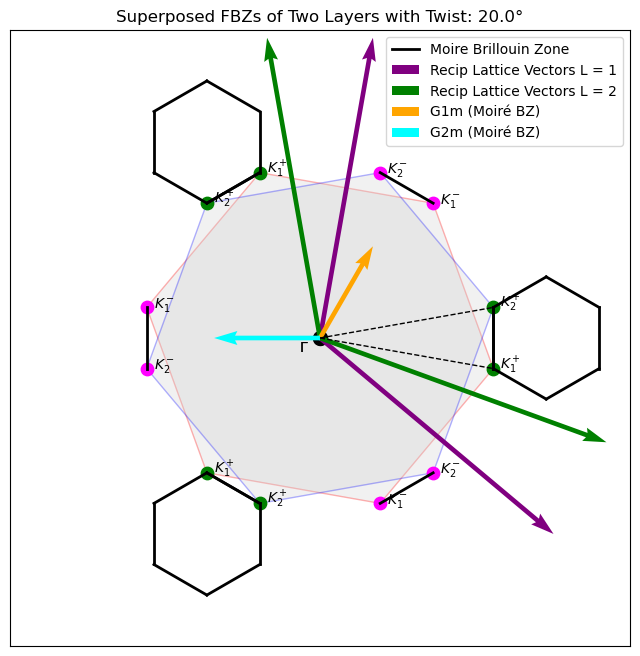

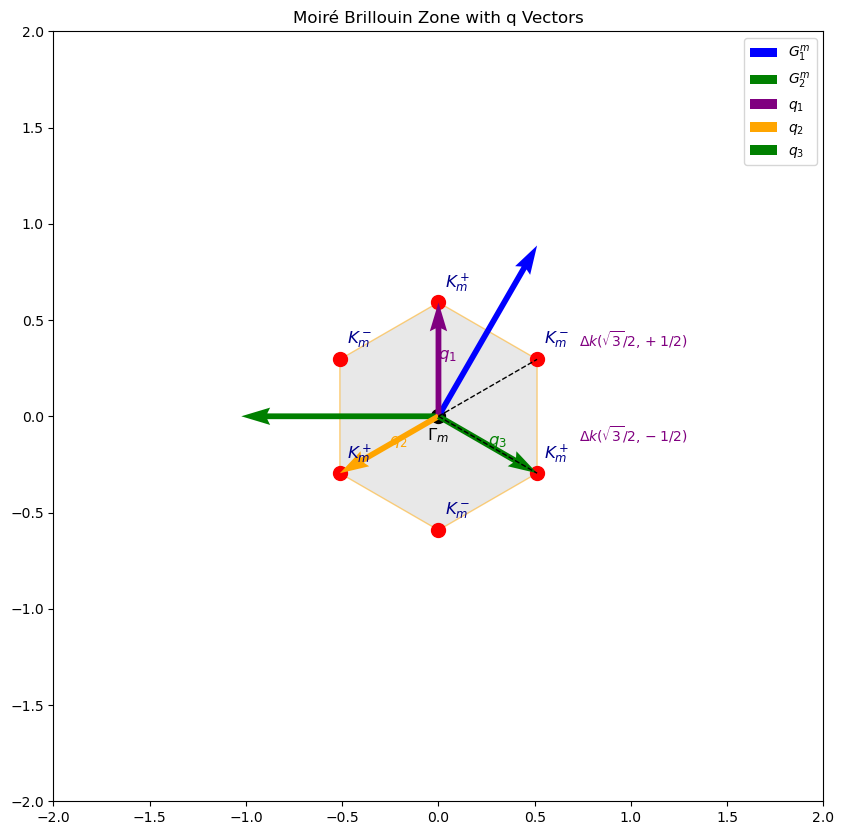

Plot: 20 degrees For Visualization


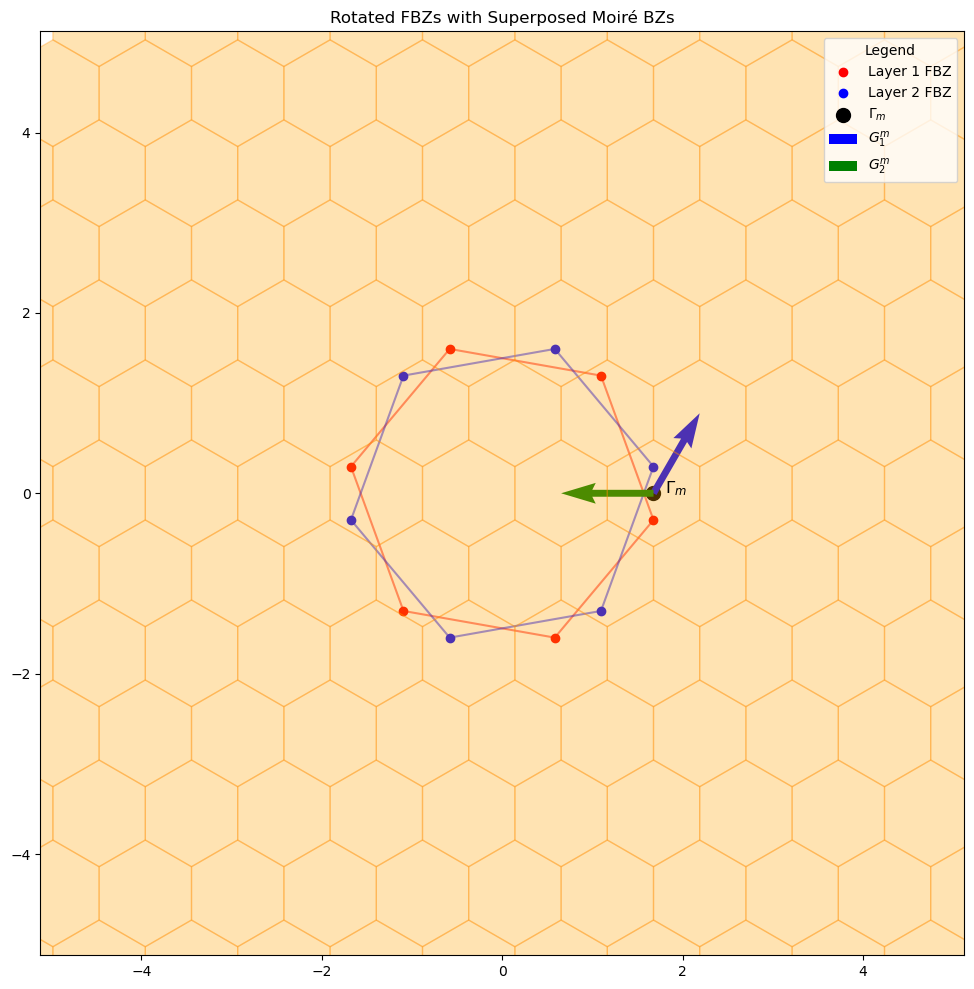

Plot: 2 degrees: Not Centered At Gamma This is just to give a sense of the extent reciprocal space shrinks with small rotation angles


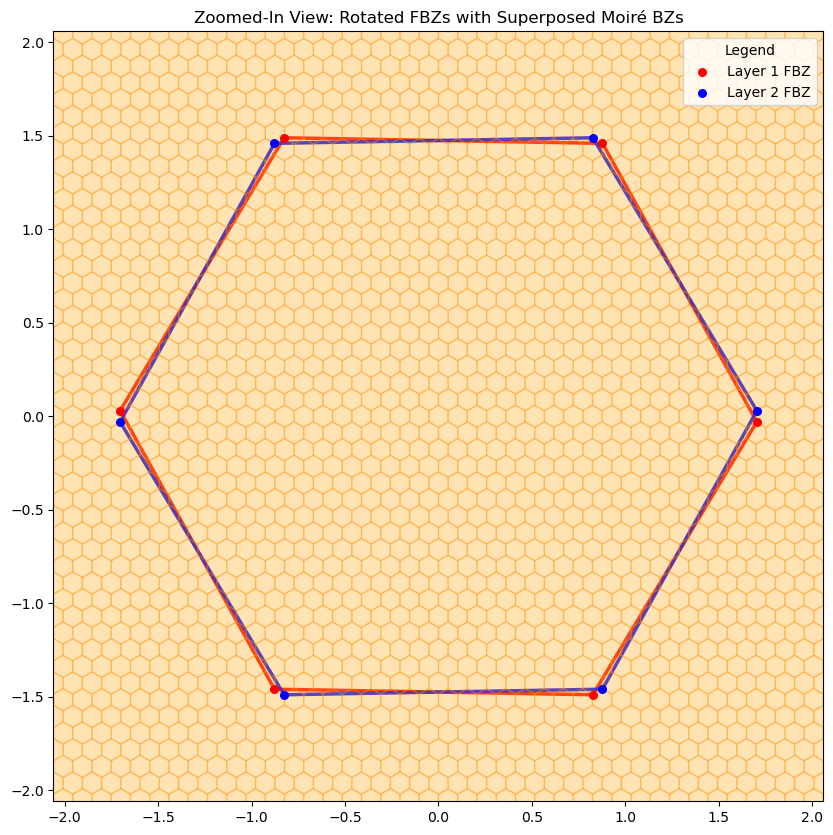

Plot: 5 degrees Zoomed In This Plot Does have correct centering to give an idea on why we must comput H across a few moire BZ momentum values for every k point on the path


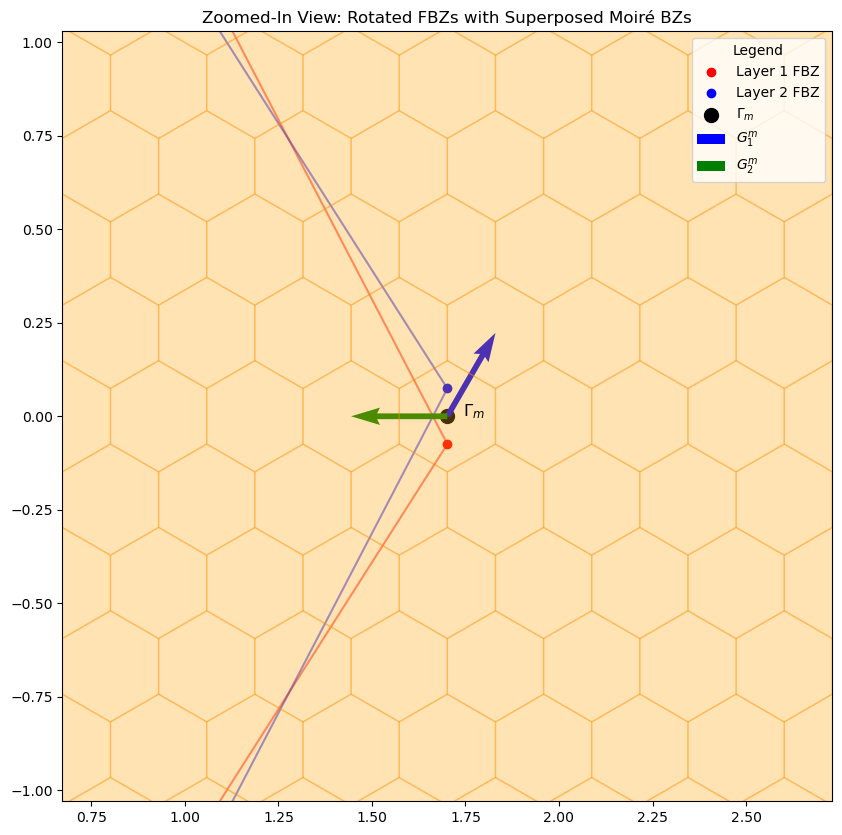

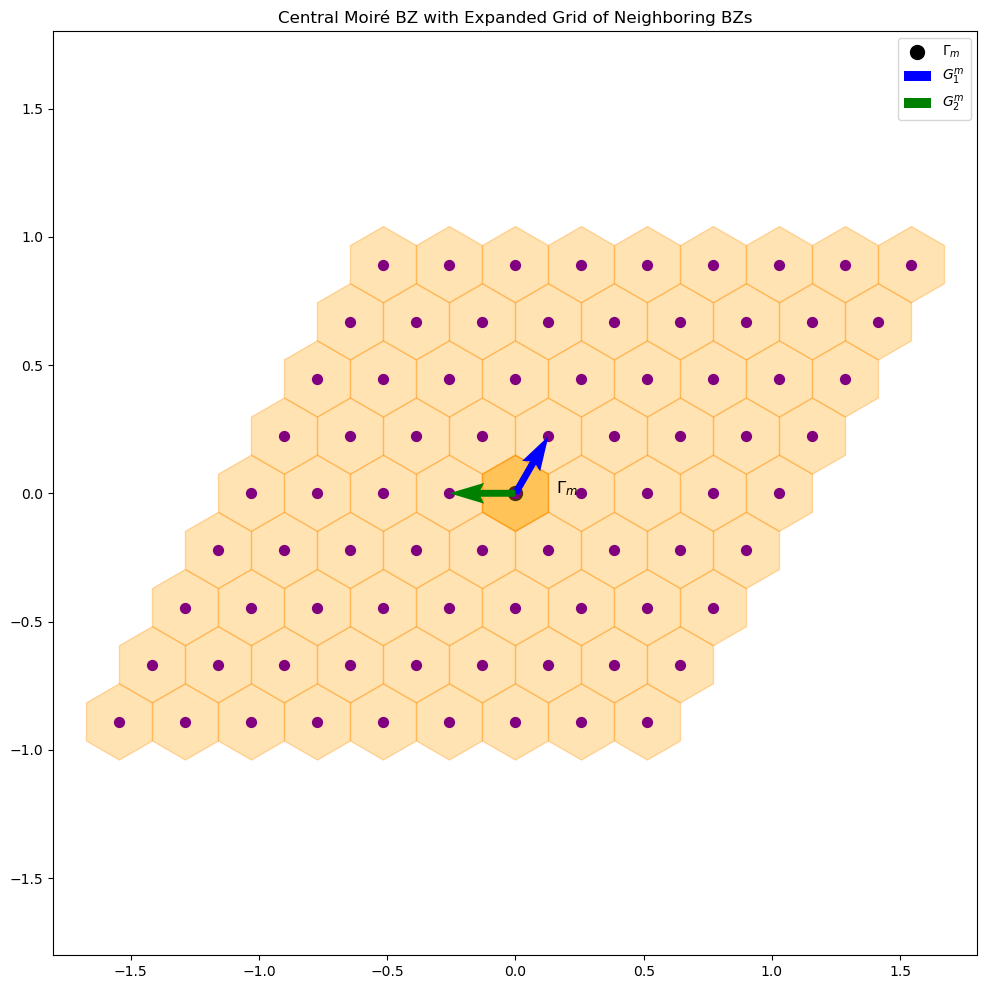

In [509]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import Voronoi, ConvexHull
from scipy.spatial.distance import cdist

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

# Rotation matrix function
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

def rotate_vector(vector, angle_rad):
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                [np.sin(angle_rad),  np.cos(angle_rad)]])
    return np.dot(rotation_matrix, vector)

# Function to plot the FBZ for both layers in a single plot
def plot_fbz_superposed(b, theta1, theta2,K1_plus, K2_plus, b1_rotated, b2_rotated,G1m,G2m):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.title(f'Superposed FBZs of Two Layers with Twist: {(theta2 - theta1)*(180/np.pi)}°')

    # Layer 1 FBZ (Rotated by theta1)
    K_vertices1, K_prime_vertices1 = plot_fbz_layer(b, theta1, layer=1, color='red', ax=ax, K_plus_label='$K_1^+$', K_minus_label="$K_1^-$")

    # Layer 2 FBZ (Rotated by theta2)
    K_vertices2, K_prime_vertices2 = plot_fbz_layer(b, theta2, layer=2, color='blue', ax=ax, K_plus_label='$K_2^+$', K_minus_label="$K_2^-$")

    # Find the closest pair of adjacent K+ points between the two layers
    distances = cdist(K_vertices1, K_vertices2)  # Compute pairwise distances
    min_distance_idx = np.unravel_index(np.argmin(distances), distances.shape)
    closest_K1 = K_vertices1[0]
    closest_K2 = K_vertices2[1]


    
    # Plot dashed line from Gamma to the closest pair of K+ points of both layers
    Gamma = np.array([0, 0])
    ax.plot([Gamma[0], closest_K1[0]], [Gamma[1], closest_K1[1]], 'k--', lw=1)  # Line to K1+
    ax.plot([Gamma[0], closest_K2[0]], [Gamma[1], closest_K2[1]], 'k--', lw=1)  # Line to K2+

    
    
    # Draw solid lines between adjacent K+ and K- points for both layers
    i = 0
    for K1, K2 in zip(K_vertices1, K_vertices2):
        K2 = K_vertices2[(i + 1) % len(K_vertices2)] # access next element of array rather than standard first element (with wrap around)
        ax.plot([K1[0], K2[0]], [K1[1], K2[1]], 'k-', lw=2)  # Solid line between adjacent K+ points
        i = i + 1
    i = 0
    for K_prime1, K_prime2 in zip(K_prime_vertices1, K_prime_vertices2):
        K_prime2 = K_prime_vertices2[(i + 1) % len(K_vertices2)]
        ax.plot([K_prime1[0], K_prime2[0]], [K_prime1[1], K_prime2[1]], 'k-', lw=2)  # Solid line between adjacent K- points
        i = i + 1



    """ PLOT MOIRE BZ Across Pairs of K-Valleys"""
    def rotate_around_point(point, origin, angle_rad):
        translation = point - origin
        rotated_translation = np.dot(rotation_matrix(angle_rad), translation)
        return rotated_translation + origin

    ax.plot([K1_plus[0], K2_plus[0]], [K1_plus[1], K2_plus[1]], 'k-', lw=2, label="Moire Brillouin Zone")
    rotated_K1_120 = rotate_around_point(K1_plus, np.array([0,0]), np.radians(120))
    rotated_K2_120 = rotate_around_point(K2_plus, np.array([0,0]), np.radians(120))
    rotated_K1_240 = rotate_around_point(K1_plus, np.array([0,0]), np.radians(240))
    rotated_K2_240 = rotate_around_point(K2_plus, np.array([0,0]), np.radians(240))

    ax.plot([rotated_K1_120[0], rotated_K2_120[0]], [rotated_K1_120[1], rotated_K2_120[1]], 'k-', lw=2)
    ax.plot([rotated_K1_240[0], rotated_K2_240[0]], [rotated_K1_240[1], rotated_K2_240[1]], 'k-', lw=2)

    # Iteratively rotate and plot the new line segments
    current_K1 = K1_plus
    current_K1_120 = rotated_K1_120
    current_K1_240 = rotated_K2_120
    current_K2 = K2_plus
    current_K2_120 = rotated_K1_240
    current_K2_240 = rotated_K2_240
    
    for i in range(5):
        next_K1 = rotate_around_point(current_K2, current_K1, np.radians(-120))
        next_K2 = rotate_around_point(current_K1, current_K1, np.radians(-120))
        
        next_K1_120 = rotate_around_point(next_K1, np.array([0,0]), np.radians(120))
        next_K2_120 = rotate_around_point(next_K2 , np.array([0,0]), np.radians(120))
        next_K1_240 = rotate_around_point(next_K1, np.array([0,0]), np.radians(240))
        next_K2_240 = rotate_around_point(next_K2 , np.array([0,0]), np.radians(240))

        
        
        ax.plot([next_K1[0], next_K2[0]], [next_K1[1], next_K2[1]], 'k-', lw=2 )    
        ax.plot([next_K1_120[0], next_K2_120[0]], [next_K1_120[1], next_K2_120[1]], 'k-', lw=2)
        ax.plot([next_K1_240[0], next_K2_240[0]], [next_K1_240[1], next_K2_240[1]], 'k-', lw=2)


        # Update for next iteration
        current_K1 = next_K1
        current_K2 = next_K2

    origin = np.array([0, 0])
    ax.quiver(origin[0], origin[1], b1_rotated[0][0], b1_rotated[0][1], angles='xy', scale_units='xy', scale=1, color='purple', label='Recip Lattice Vectors L = 1')
    ax.quiver(origin[0], origin[1], b1_rotated[1][0], b1_rotated[1][1], angles='xy', scale_units='xy', scale=1, color='purple')

    ax.quiver(origin[0], origin[1], b2_rotated[0][0], b2_rotated[0][1], angles='xy', scale_units='xy', scale=1, color='green', label='Recip Lattice Vectors L = 2')
    ax.quiver(origin[0], origin[1], b2_rotated[1][0], b2_rotated[1][1], angles='xy', scale_units='xy', scale=1, color='green')

    origin = np.array([0, 0])
    ax.quiver(origin[0], origin[1], G1m[0], G1m[1], angles='xy', scale_units='xy', scale=1, color='orange', label='G1m (Moiré BZ)')
    ax.quiver(origin[0], origin[1], G2m[0], G2m[1], angles='xy', scale_units='xy', scale=1, color='cyan', label='G2m (Moiré BZ)')



    plt.axis('equal')
    plt.xlim([-3.0, 3.0])
    plt.ylim([-3.0, 3.0])
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.show()

# Helper function to plot a single layer's FBZ on the given axes
def plot_fbz_layer(b, theta, layer, color, ax, K_plus_label='$K_{{{}}}^+$', K_minus_label="$K_{{{}}}^-$"):
    rotation = rotation_matrix(theta)
    b_rotated = np.dot(b, rotation.T)

    # Generate reciprocal lattice points
    N = 1  # Include immediate neighbors
    reciprocal_lattice_points = []
    b1, b2 = b_rotated[0], b_rotated[1]
    for n in range(-N, N + 1):
        for m in range(-N, N + 1):
            K_point = n * b1 + m * b2
            reciprocal_lattice_points.append(K_point)
    reciprocal_lattice_points = np.array(reciprocal_lattice_points)

    # Create Voronoi diagram to find the FBZ
    vor = Voronoi(reciprocal_lattice_points)

    # Identify the region corresponding to the origin (Gamma point)
    center_indices = np.where(np.all(np.isclose(reciprocal_lattice_points, [0, 0], atol=1e-8), axis=1))[0]
    center_index = center_indices[0]
    center_region_index = vor.point_region[center_index]
    center_region = vor.regions[center_region_index]

    # Get the vertices of the FBZ
    vertices = vor.vertices[center_region]

    # Order the vertices counter-clockwise
    hull = ConvexHull(vertices)
    vertices = vertices[hull.vertices]

    # High-symmetry points
    Gamma = np.array([0, 0])

    # Compute the K and K' points explicitly
    K_point = (2 * b_rotated[0] + b_rotated[1]) / 3
    K_prime_point = -K_point  # Inversion through Gamma point

    # Identify the K and K' points among the vertices
    K_vertices = []
    K_prime_vertices = []
    for vertex in vertices:
        matched = False
        for n in [-1, 0, 1]:
            for m in [-1, 0, 1]:
                shift = n * b_rotated[0] + m * b_rotated[1]
                if np.allclose(vertex, K_point + shift, atol=1e-8):
                    K_vertices.append(vertex)
                    matched = True
                    break
                elif np.allclose(vertex, K_prime_point + shift, atol=1e-8):
                    K_prime_vertices.append(vertex)
                    matched = True
                    break
            if matched:
                break

    # Plot the FBZ polygon
    polygon = Polygon(vertices, closed=True, facecolor='lightgray', edgecolor=color, alpha=0.3)
    ax.add_patch(polygon)

    # Mark and label the Gamma point
    ax.scatter(Gamma[0], Gamma[1], color='black', s=100)
    ax.annotate('$\\Gamma$', xy=(Gamma[0], Gamma[1]), xytext=(-15, -10), textcoords='offset points')

    # Label K points
    for K in K_vertices:
        ax.scatter(K[0], K[1], color='green', s=80)
        ax.annotate(K_plus_label.format(layer), xy=(K[0], K[1]), xytext=(5, 0), textcoords='offset points')

    # Label K' points
    for K_prime in K_prime_vertices:
        ax.scatter(K_prime[0], K_prime[1], color='magenta', s=80)
        ax.annotate(K_minus_label.format(layer), xy=(K_prime[0], K_prime[1]), xytext=(5, 0), textcoords='offset points')

    
    


    return K_vertices, K_prime_vertices

def plot_moireBZ(G1m, G2m, K1_plus, K2_plus, ax=None):
    """
    Plots the hexagonal Moiré Brillouin Zone (BZ) with the Moiré lattice vectors G1m and G2m,
    and includes vectors q1, q2, and q3 originating from the central Gamma point.
    
    Parameters:
    - G1m, G2m: Moiré lattice vectors.
    - K1_plus, K2_plus: Points defining q1 as K2+ - K1+.
    - ax: Optional Matplotlib axes to plot on. If None, a new plot is created.
    """
    
    # Define rotation matrix function
    def rotate_vector(vector, angle_rad):
        rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                    [np.sin(angle_rad),  np.cos(angle_rad)]])
        return np.dot(rotation_matrix, vector)

    # Compute the q vectors
    q1 = K2_plus - K1_plus
    q2 = rotate_vector(q1, 2 * np.pi / 3)
    q3 = rotate_vector(q1, 4 * np.pi / 3)

    # Initialize plot if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
        ax.set_title('Moiré Brillouin Zone with q Vectors')

    # Plot the Moiré BZ
    def rotate_hexagon_vertices(G1m, G2m):
        vertex1 = 2/3 * G1m + 1/3 * G2m
        vertices = [vertex1]
        for _ in range(5):
            vertex1 = rotate_vector(vertex1, np.radians(60))
            vertices.append(vertex1)
        return np.array(vertices)

    # Draw the hexagonal Moiré BZ
    vertices = rotate_hexagon_vertices(G1m, G2m)
    polygon = Polygon(vertices, closed=True, facecolor='lightgray', edgecolor='orange', alpha=0.5)
    ax.add_patch(polygon)

    # Label each vertex as either K_m^+ or K_m^-
    for i, vertex in enumerate(vertices):
        ax.scatter(vertex[0], vertex[1], color='red', s=100)  # Plot the vertex
        label = r"$K_m^+$" if i % 2 == 0 else r"$K_m^-$"  # Alternate between K_m^+ and K_m^-
        offset_x, offset_y = (0.1, 0.1)
        ax.text(vertex[0] + offset_x, vertex[1] + offset_y, label, fontsize=12, ha='center', va='center', color='darkblue')

    # Plot Gamma_m (origin)  # Slight offset for visibility
    Gamma_m = np.array([0.00, 0.00]) 
    ax.scatter(Gamma_m[0], Gamma_m[1], color='black', s=100)
    ax.text(Gamma_m[0], Gamma_m[1] - 0.125, r'$\Gamma_m$', fontsize=12, ha='center', color='black')
    
    # Define two labeled K points in the Moiré BZ
    k_point1 = vertices[4]  # Choose a vertex on the Moiré BZ
    k_point2 = vertices[5]  # Another vertex on the Moiré BZ
    
    # Plot dashed lines from Gamma_m to selected K points
    ax.plot([Gamma_m[0], k_point1[0]], [Gamma_m[1], k_point1[1]], 'k--', lw=1)
    ax.plot([Gamma_m[0], k_point2[0]], [Gamma_m[1], k_point2[1]], 'k--', lw=1)
    
    # Label the K points with specified labels
    ax.text(k_point1[0]+0.5, k_point1[1]+0.2, r'$\Delta k (\sqrt{3}/2, -1/2)$', fontsize=10, ha='center', va='center', color='purple')
    ax.text(k_point2[0]+0.5, k_point2[1]+0.1, r'$\Delta k (\sqrt{3}/2, +1/2)$', fontsize=10, ha='center', va='center', color='purple')

    

    # Plot G1m and G2m vectors using quivers
    ax.quiver(Gamma_m[0], Gamma_m[1], G1m[0], G1m[1], angles='xy', scale_units='xy', scale=1, color='blue', label='$G_1^m$')
    ax.quiver(Gamma_m[0], Gamma_m[1], G2m[0], G2m[1], angles='xy', scale_units='xy', scale=1, color='green', label='$G_2^m$')

    # Plot q1, q2, and q3 vectors
    ax.quiver(Gamma_m[0], Gamma_m[1], q1[0], q1[1], angles='xy', scale_units='xy', scale=1, color='purple', label=r'$q_1$')
    ax.quiver(Gamma_m[0], Gamma_m[1], q2[0], q2[1], angles='xy', scale_units='xy', scale=1, color='orange', label=r'$q_2$')
    ax.quiver(Gamma_m[0], Gamma_m[1], q3[0], q3[1], angles='xy', scale_units='xy', scale=1, color='green', label=r'$q_3$')

    # Label q vectors for clarity
    ax.text(q1[0] * 0.5, q1[1] * 0.5, r'$q_1$', color='purple', fontsize=12)
    ax.text(q2[0] * 0.5, q2[1] * 0.5, r'$q_2$', color='orange', fontsize=12)
    ax.text(q3[0] * 0.5, q3[1] * 0.5, r'$q_3$', color='green', fontsize=12)

    # Ensure equal aspect ratio and expand plot limits
    ax.set_aspect('equal')
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.legend()
    plt.show()

def plot_mbZ_onFBZ(b, theta1, theta2, G1m, G2m, K1_plus, K2_plus):
    """
    Plots rotated FBZs for two layers with angles theta1 and theta2 and overlays multiple Moiré BZs.
    Parameters:
    - b: Reciprocal lattice vectors.
    - theta1, theta2: Rotation angles for the two layers.
    - G1m, G2m: Moiré lattice vectors.
    - K1_plus, K2_plus: Points defining the Moiré center.
    """
    
    def get_hexagon_vertices(b_rotated):
        vertex1 = 2 / 3 * b_rotated[0] + 1 / 3 * b_rotated[1]
        vertices = [vertex1]
        for _ in range(5):
            vertex1 = np.dot(rotation_matrix(np.radians(60)), vertex1)
            vertices.append(vertex1)
        return np.array(vertices)

    fig, ax = plt.subplots(figsize=(12, 12))  # Larger size to capture everything
    ax.set_title('Rotated FBZs with Superposed Moiré BZs')

    # Rotate and plot each FBZ as a hexagon
    for layer, theta in enumerate([theta1, theta2], start=1):
        b_rotated = np.dot(b, rotation_matrix(theta).T)
        vertices = get_hexagon_vertices(b_rotated)
        color = 'red' if layer == 1 else 'blue'
        polygon = Polygon(vertices, closed=True, facecolor='none', edgecolor=color, alpha=0.5, linewidth=1.5)
        ax.add_patch(polygon)
        ax.scatter(vertices[:, 0], vertices[:, 1], color=color, label=f'Layer {layer} FBZ')

    # Moiré BZ vertices function
    def get_moire_vertices(G1m, G2m):
        vertex1 = 2 / 3 * G1m + 1 / 3 * G2m
        vertices = [vertex1]
        for _ in range(5):
            vertex1 = np.dot(rotation_matrix(np.radians(60)), vertex1)
            vertices.append(vertex1)
        return np.array(vertices)

    # Calculate the center for Moiré BZs based on midpoint of K1_plus and K2_plus
    moire_center = (K1_plus + K2_plus) / 2

    # Create grid of centers for the Moiré BZs
    grid_size = 9
    centers = [i * G1m + j * G2m + moire_center for i in range(-grid_size, grid_size + 1) for j in range(-grid_size, grid_size + 1)]

    # Overlay each Moiré BZ centered at each grid point
    for i, center in enumerate(centers):
        moire_vertices = get_moire_vertices(G1m, G2m) + center
        moire_polygon = Polygon(moire_vertices, closed=True, facecolor='orange', edgecolor='darkorange', alpha=0.3)
        ax.add_patch(moire_polygon)

        # Label the first Moiré BZ center as Γ_m with Greek letter
        if i == 0:
            ax.scatter(moire_center[0], moire_center[1], color='black', s=100, label=r'$\Gamma_m$')
            ax.text(moire_center[0]+0.25, moire_center[1], r'$\Gamma_m$', fontsize=12, ha='center', color='black')

            # Plot G1m and G2m vectors from the Moiré center
            ax.quiver(moire_center[0], moire_center[1], G1m[0], G1m[1], angles='xy', scale_units='xy', scale=1, color='blue', label='$G_1^m$')
            ax.quiver(moire_center[0], moire_center[1], G2m[0], G2m[1], angles='xy', scale_units='xy', scale=1, color='green', label='$G_2^m$')

    # Set plot limits to ensure everything is visible
    plot_extent = 5 * np.max([np.linalg.norm(G1m), np.linalg.norm(G2m)])
    ax.set_xlim([-plot_extent, plot_extent])
    ax.set_ylim([-plot_extent, plot_extent])
    ax.set_aspect('equal')

    # Update legend location and add Moiré BZ label
    ax.legend(loc='upper right', title="Legend")
    plt.show()


def plot_mbZ_onFBZ1(b, theta1, theta2, G1m, G2m, K1_plus, K2_plus):
    """
    Plots rotated FBZs for two layers with angles theta1 and theta2 and overlays multiple Moiré BZs.
    Parameters:
    - b: Reciprocal lattice vectors.
    - theta1, theta2: Rotation angles for the two layers.
    - G1m, G2m: Moiré lattice vectors.
    - K1_plus, K2_plus: Points defining the Moiré center.
    """
    
    def rotation_matrix(theta):
        return np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
    
    def get_hexagon_vertices(b_rotated):
        vertex1 = 2 / 3 * b_rotated[0] + 1 / 3 * b_rotated[1]
        vertices = [vertex1]
        for _ in range(5):
            vertex1 = np.dot(rotation_matrix(np.radians(60)), vertex1)
            vertices.append(vertex1)
        return np.array(vertices)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Zoomed-In View: Rotated FBZs with Superposed Moiré BZs')

    # Rotate and plot each FBZ as a hexagon
    for layer, theta in enumerate([theta1, theta2], start=1):
        b_rotated = np.dot(b, rotation_matrix(theta).T)
        vertices = get_hexagon_vertices(b_rotated)
        color = 'red' if layer == 1 else 'blue'
        polygon = Polygon(vertices, closed=True, facecolor='none', edgecolor=color, alpha=0.5, linewidth=1.5)
        ax.add_patch(polygon)
        ax.scatter(vertices[:, 0], vertices[:, 1], color=color, label=f'Layer {layer} FBZ')

    # Moiré BZ vertices function
    def get_moire_vertices(G1m, G2m):
        vertex1 = 2 / 3 * G1m + 1 / 3 * G2m
        vertices = [vertex1]
        for _ in range(5):
            vertex1 = np.dot(rotation_matrix(np.radians(60)), vertex1)
            vertices.append(vertex1)
        return np.array(vertices)

    # Calculate the center for Moiré BZs based on midpoint of K1_plus and K2_plus
    moire_center = (K1_plus + K2_plus) / 2

    # Create a smaller grid of Moiré BZs around the main center for a zoomed-in view
    grid_size = 25  # Reduce grid size to focus around the main Moiré BZ
    centers = [i * G1m + j * G2m + moire_center for i in range(-grid_size, grid_size + 1) for j in range(-grid_size, grid_size + 1)]

    # Overlay each Moiré BZ centered at each grid point
    for i, center in enumerate(centers):
        moire_vertices = get_moire_vertices(G1m, G2m) + center
        moire_polygon = Polygon(moire_vertices, closed=True, facecolor='orange', edgecolor='darkorange', alpha=0.3)
        ax.add_patch(moire_polygon)

        # Label the first Moiré BZ center as Γ_m with Greek letter
        if i == 0:
            ax.scatter(moire_center[0], moire_center[1], color='black', s=100, label=r'$\Gamma_m$')
            ax.text(moire_center[0]+0.07, moire_center[1], r'$\Gamma_m$', fontsize=12, ha='center', color='black')

            # Plot G1m and G2m vectors from the Moiré center
            ax.quiver(moire_center[0], moire_center[1], G1m[0], G1m[1], angles='xy', scale_units='xy', scale=1, color='blue', label='$G_1^m$')
            ax.quiver(moire_center[0], moire_center[1], G2m[0], G2m[1], angles='xy', scale_units='xy', scale=1, color='green', label='$G_2^m$')

    # Set tighter plot limits around the main Moiré BZ
    plot_extent = 4 * np.linalg.norm(G1m)
    ax.set_xlim([moire_center[0] - plot_extent, moire_center[0] + plot_extent])
    ax.set_ylim([moire_center[1] - plot_extent, moire_center[1] + plot_extent])
    ax.set_aspect('equal')

    # Update legend location and add Moiré BZ label
    ax.legend(loc='upper right', title="Legend")
    plt.show()


def plot_mbZ_onFBZ2(b, theta1, theta2, G1m, G2m):
    """
    Plots rotated FBZs for two layers with angles theta1 and theta2 and overlays multiple Moiré BZs.
    The plot is centered at (0, 0) to visualize the scaling effect of the Moiré BZs relative to the FBZ.
    
    Parameters:
    - b: Reciprocal lattice vectors.
    - theta1, theta2: Rotation angles for the two layers.
    - G1m, G2m: Moiré lattice vectors.
    """
    
    def rotation_matrix(theta):
        return np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta),  np.cos(theta)]
        ])
    
    def get_hexagon_vertices(b_rotated):
        vertex1 = 2 / 3 * b_rotated[0] + 1 / 3 * b_rotated[1]
        vertices = [vertex1]
        for _ in range(5):
            vertex1 = np.dot(rotation_matrix(np.radians(60)), vertex1)
            vertices.append(vertex1)
        return np.array(vertices)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title('Zoomed-In View: Rotated FBZs with Superposed Moiré BZs')

    # Rotate and plot each FBZ as a hexagon
    for layer, theta in enumerate([theta1, theta2], start=1):
        b_rotated = np.dot(b, rotation_matrix(theta).T)
        vertices = get_hexagon_vertices(b_rotated)
        color = 'red' if layer == 1 else 'blue'
        polygon = Polygon(vertices, closed=True, facecolor='none', edgecolor=color, alpha=0.9, linewidth=2.5)
        ax.add_patch(polygon)
        ax.scatter(vertices[:, 0], vertices[:, 1], color=color, s=30, zorder=5, label=f'Layer {layer} FBZ')

    # Moiré BZ vertices function
    def get_moire_vertices(G1m, G2m):
        vertex1 = 2 / 3 * G1m + 1 / 3 * G2m
        vertices = [vertex1]
        for _ in range(5):
            vertex1 = np.dot(rotation_matrix(np.radians(60)), vertex1)
            vertices.append(vertex1)
        return np.array(vertices)

    # Define the Moiré center at origin
    moire_center = np.array([0.0, 0.0])

    # Create a limited grid of Moiré BZs around the origin
    grid_size = 33  # Adjust grid size as needed to show the extent of the MBZs
    centers = [i * G1m + j * G2m + moire_center for i in range(-grid_size, grid_size + 1) for j in range(-grid_size, grid_size + 1)]

    # Overlay each Moiré BZ centered at each grid point
    for center in centers:
        moire_vertices = get_moire_vertices(G1m, G2m) + center
        moire_polygon = Polygon(moire_vertices, closed=True, facecolor='orange', edgecolor='darkorange', alpha=0.3)
        ax.add_patch(moire_polygon)

    # Dynamically set plot limits based on Moiré grid size and ensure equal aspect ratio
    plot_extent = 20 * np.linalg.norm(G1m)
    ax.set_xlim([-plot_extent, plot_extent])
    ax.set_ylim([-plot_extent, plot_extent])
    ax.set_aspect('equal')

    # Update legend location
    ax.legend(loc='upper right', title="Legend")
    plt.show()



def plot_central_mBZ_with_k_grid(G1m, G2m):
    """
    Plots the central Moiré Brillouin Zone (BZ) along with a larger grid of neighboring MBZs
    in a 9x9 grid defined by shifts along the Moiré reciprocal lattice vectors G1m and G2m.
    """
    fig, ax = plt.subplots(figsize=(12, 12))  # Increase figure size for better visibility
    ax.set_title("Central Moiré BZ with Expanded Grid of Neighboring BZs")

    # Define the central Moiré BZ
    moire_center = np.array([0, 0])  # Centered at the origin

    # Function to calculate vertices for a single Moiré BZ
    def get_moire_vertices(G1m, G2m):
        vertex1 = 2 / 3 * G1m + 1 / 3 * G2m
        vertices = [vertex1]
        for _ in range(5):
            vertex1 = np.dot(rotation_matrix(np.radians(60)), vertex1)
            vertices.append(vertex1)
        return np.array(vertices)

    # Calculate vertices for the central Moiré BZ
    central_moire_vertices = get_moire_vertices(G1m, G2m) + moire_center
    polygon = Polygon(central_moire_vertices, closed=True, facecolor='orange', edgecolor='darkorange', alpha=0.5)
    ax.add_patch(polygon)

    # Label the central Moiré BZ center as Γ_m with Greek letter
    ax.scatter(moire_center[0], moire_center[1], color='black', s=100, label=r'$\Gamma_m$')
    ax.text(moire_center[0] + 0.2, moire_center[1], r'$\Gamma_m$', fontsize=12, ha='center', color='black')

    # Define an expanded grid for additional MBZs (from -4 to +4 in each direction)
    n_range = range(-4, 5)  # Grid size for additional MBZs
    centers = [n1 * G1m + n2 * G2m + moire_center for n1 in n_range for n2 in n_range]

    # Overlay each Moiré BZ centered at each grid point and add a center point
    for center in centers:
        moire_vertices = get_moire_vertices(G1m, G2m) + center
        moire_polygon = Polygon(moire_vertices, closed=True, facecolor='orange', edgecolor='darkorange', alpha=0.3)
        ax.add_patch(moire_polygon)
        
        # Plot a point at the center of each MBZ
        ax.scatter(center[0], center[1], color='purple', s=50, marker='o')  # Center point of each MBZ

    # Plot G1m and G2m vectors at the origin
    ax.quiver(0, 0, G1m[0], G1m[1], angles='xy', scale_units='xy', scale=1, color='blue', label='$G_1^m$')
    ax.quiver(0, 0, G2m[0], G2m[1], angles='xy', scale_units='xy', scale=1, color='green', label='$G_2^m$')

    # Set plot limits to capture the expanded grid and ensure equal aspect ratio
    plot_extent = 7 * np.linalg.norm(G1m)
    ax.set_xlim([-plot_extent, plot_extent])
    ax.set_ylim([-plot_extent, plot_extent])
    ax.set_aspect('equal')

    # Update legend location
    ax.legend(loc='upper right')
    plt.show()



# Main function
def main():

    # **Relevant Parameters**
    t = 2700  # Hopping parameter (meV) (Intralayer)
    w0 = 110  # AB hopping amplitude
    w1 = 65   # AA hopping amplitude
    
    # Carbon-carbon bond distance (Ångströms)
    a0 = 1.42
    # Lattice constant (Ångströms)
    d = a0 * np.sqrt(3)
    
    # Reciprocal lattice constant (1/Å)
    kD = 4 * np.pi / (3 * a0 * np.sqrt(3))
    
    a0 = 1.42  # Carbon-carbon bond distance (Ångströms)
    d = a0 * np.sqrt(3)  # Lattice constant
    a = np.array([
        [d, 0],
        d * np.array([0.5, np.sqrt(3)/2])
    ])

    # Get reciprocal lattice vectors
    b = get_reciprocal_lattice_vectors(a)

    # Set rotation angles
    theta = 20
    theta_rad = np.radians(theta)
    theta1 = np.radians(-theta / 2)  # Rotation for layer 1
    theta2 = np.radians(theta / 2)   # Rotation for layer 2


    # Rotation of Reciprocal Lattice Vectors
    b1_rotated = np.dot(b, rotation_matrix(theta1).T)
    b2_rotated = np.dot(b, rotation_matrix(theta2).T)

    # Compute the K points from rotated reciprocal lattice vectors
    K1_plus = (2 * b1_rotated[0] + b1_rotated[1]) / 3
    K2_plus = (2 * b2_rotated[0] + b2_rotated[1]) / 3

    moire_bz_side_length = np.linalg.norm(K2_plus - K1_plus)
    expected_side_length = 2 * kD * np.sin(theta_rad / 2)

    "Moire Reciprocal Lattice Vectors"
    
    G1m = b2_rotated[0] - b1_rotated[0]
    G2m = b2_rotated[1] - b1_rotated[1]

    
    print(moire_bz_side_length, expected_side_length)

    
    # Plot superposed FBZ for both layers
    ax = plot_fbz_superposed(b, theta1, theta2,K1_plus, K2_plus,b1_rotated, b2_rotated,G1m,G2m)
    plot_moireBZ(G1m, G2m,K1_plus, K2_plus)
    print("Plot: 20 degrees For Visualization")
    plot_mbZ_onFBZ(b, theta1, theta2, G1m, G2m,K1_plus,K2_plus)

    # Set rotation angles
    theta = 2
    theta_rad = np.radians(theta)
    theta1 = np.radians(-theta / 2)  # Rotation for layer 1
    theta2 = np.radians(theta / 2)   # Rotation for layer 2


    # Rotation of Reciprocal Lattice Vectors
    b1_rotated = np.dot(b, rotation_matrix(theta1).T)
    b2_rotated = np.dot(b, rotation_matrix(theta2).T)

    # Compute the K points from rotated reciprocal lattice vectors
    K1_plus = (2 * b1_rotated[0] + b1_rotated[1]) / 3
    K2_plus = (2 * b2_rotated[0] + b2_rotated[1]) / 3

    moire_bz_side_length = np.linalg.norm(K2_plus - K1_plus)
    expected_side_length = 2 * kD * np.sin(theta_rad / 2)

    "Moire Reciprocal Lattice Vectors"
    
    G1m = b2_rotated[0] - b1_rotated[0]
    G2m = b2_rotated[1] - b1_rotated[1]
    
    print("Plot: 2 degrees: Not Centered At Gamma This is just to give a sense of the extent reciprocal space shrinks with small rotation angles")
    plot_mbZ_onFBZ2(b, theta1, theta2, G1m, G2m)


    
    # Set rotation angles
    theta = 5
    theta_rad = np.radians(theta)
    theta1 = np.radians(-theta / 2)  # Rotation for layer 1
    theta2 = np.radians(theta / 2)   # Rotation for layer 2


    # Rotation of Reciprocal Lattice Vectors
    b1_rotated = np.dot(b, rotation_matrix(theta1).T)
    b2_rotated = np.dot(b, rotation_matrix(theta2).T)

    # Compute the K points from rotated reciprocal lattice vectors
    K1_plus = (2 * b1_rotated[0] + b1_rotated[1]) / 3
    K2_plus = (2 * b2_rotated[0] + b2_rotated[1]) / 3

    moire_bz_side_length = np.linalg.norm(K2_plus - K1_plus)
    expected_side_length = 2 * kD * np.sin(theta_rad / 2)

    "Moire Reciprocal Lattice Vectors"
    
    G1m = b2_rotated[0] - b1_rotated[0]
    G2m = b2_rotated[1] - b1_rotated[1]



    print("Plot: 5 degrees Zoomed In This Plot Does have correct centering to give an idea on why we must comput H across a few moire BZ momentum values for every k point on the path")
    plot_mbZ_onFBZ1(b, theta1, theta2, G1m, G2m,K1_plus,K2_plus)
    
    
    plot_central_mBZ_with_k_grid(G1m, G2m)






    





main()


Moiré BZ Side Length (calculated): 0.04458572793500023
Expected Side Length: 0.04458572793500016
Moiré Reciprocal Lattice Vectors G1m, G2m:
 [0.03861237 0.06687859] 
 [-0.07722475  0.        ]
Moiré Lattice Vectors R1m, R2m:
 [  0.         -81.36233042] 
 [93.94912675 46.97456337]


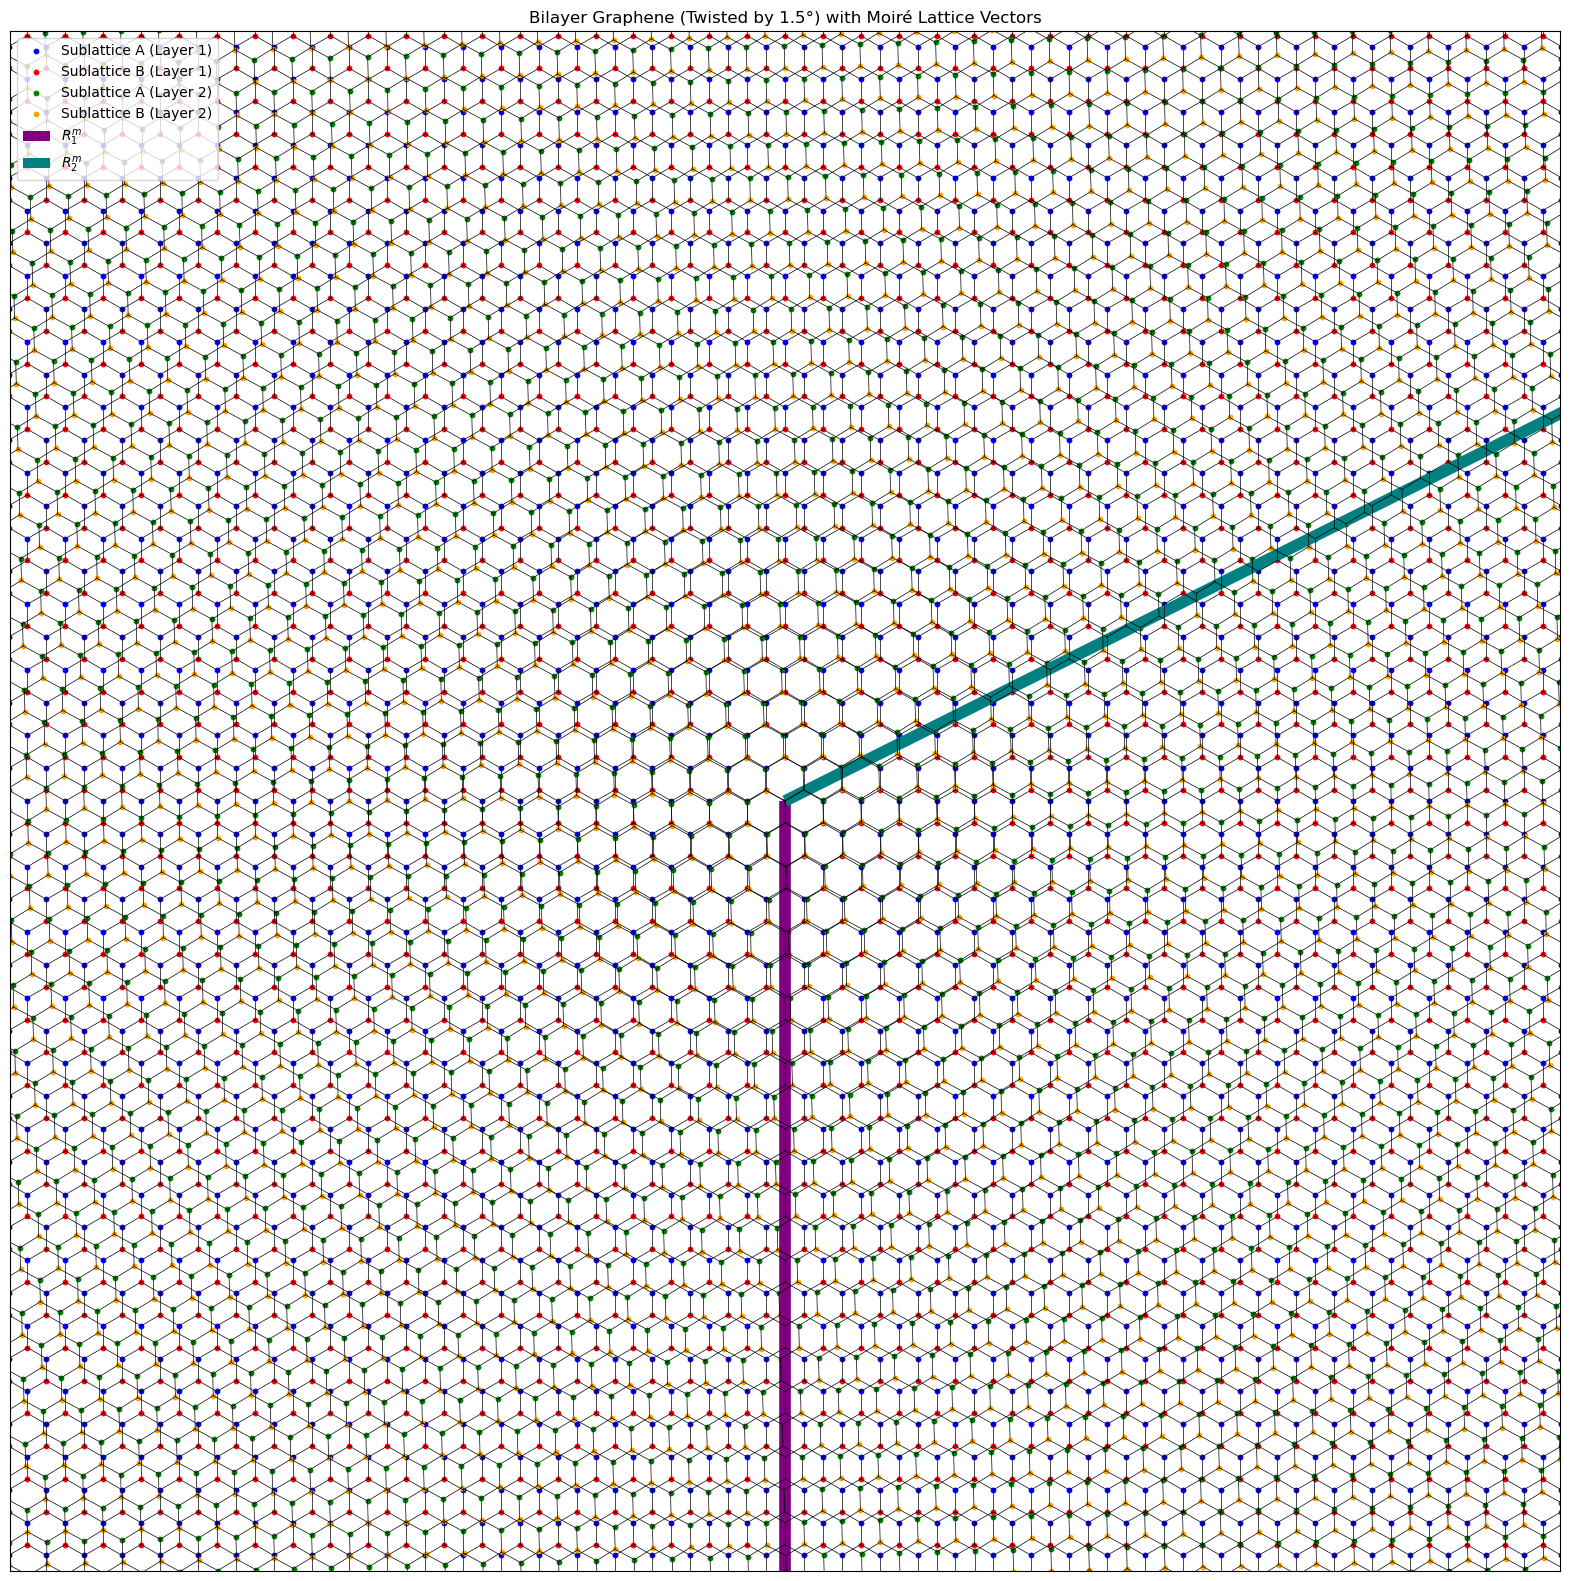

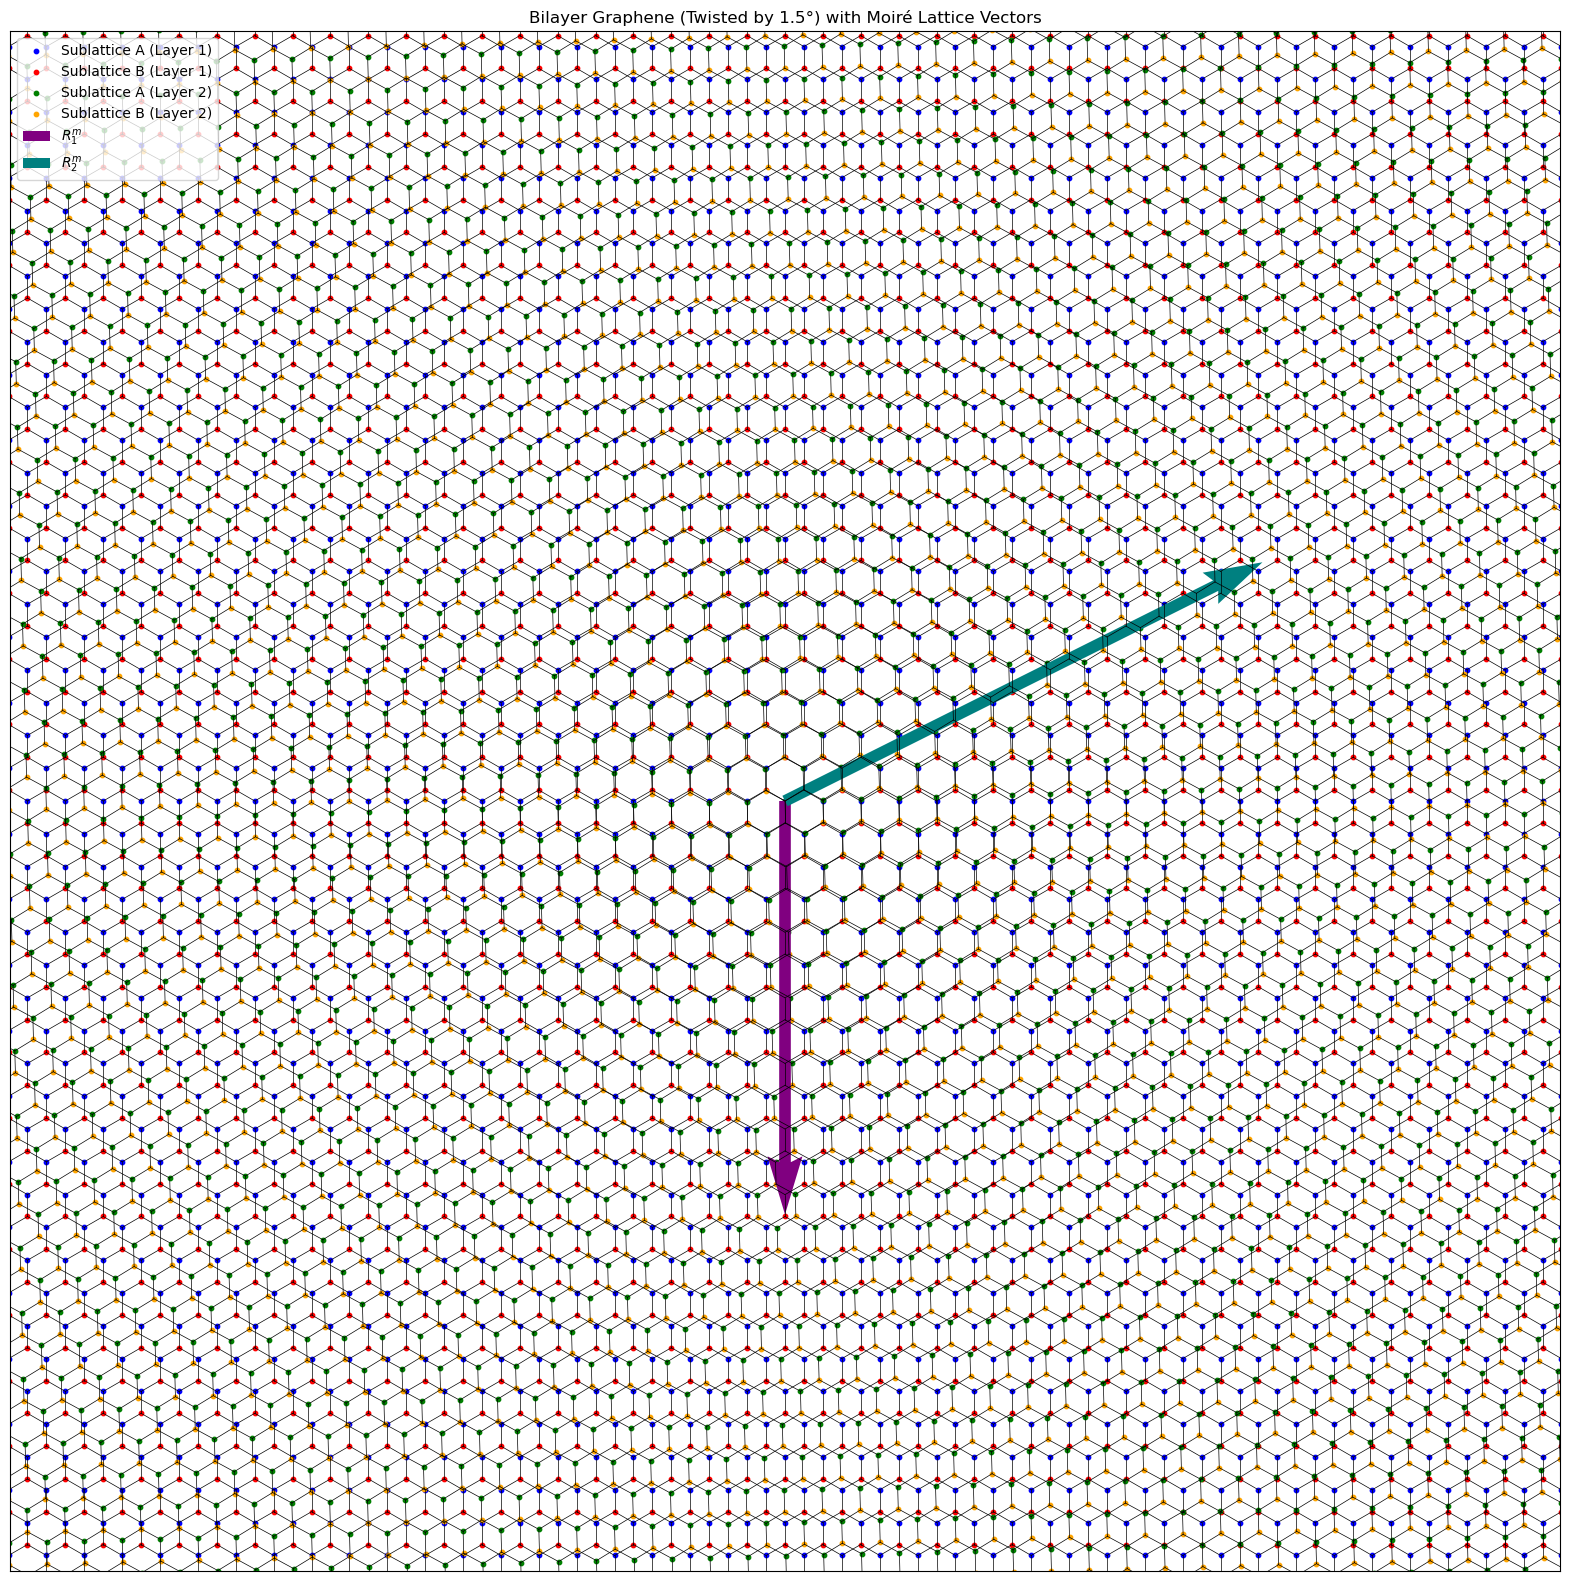

In [701]:
"""This segment finds the Moire Lattice Vectors from The Moire Reciprocal Lattice Vectors, then plots the Moire Lattice superposed on the original Lattice Layers"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import Voronoi, ConvexHull
from scipy.spatial.distance import cdist


# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

def get_lattice_vectors_from_reciprocal(B):
    B = np.array(B)  # Ensure B is a NumPy array
    B_inv = np.linalg.inv(B.T / (2 * np.pi))  # Inverse of B transposed and scaled
    R1 = B_inv[:, 0]
    R2 = B_inv[:, 1]
    return np.array([R1, R2])
# Rotation matrix function
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])


# Disable LaTeX rendering to avoid errors
rcParams['text.usetex'] = False

# **Relevant Parameters**
t = 2700  # Hopping parameter (meV) (Intralayer)
w0 = 110  # AB hopping amplitude
w1 = 65   # AA hopping amplitude

# Carbon-carbon bond distance (Ångströms)
a0 = 1.42

# Lattice constant (Ångströms)
d = a0 * np.sqrt(3)

# Reciprocal lattice constant (1/Å)
kD = 4 * np.pi / (3 * a0 * np.sqrt(3))

# **Lattice Vectors**
a = np.array([
    [d, 0],
    d * np.array([0.5, np.sqrt(3)/2])
])

# **Nearest Neighbor Vectors (Corrected)**
delta1 = -(1/3) * a[0] + (2/3) * a[1]
delta2 = (-1/3) * a[0] - (1/3) * a[1]
delta3 = (2/3) * a[0] - (1/3) * a[1]
delta = np.array([delta1, delta2, delta3])

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return b1, b2

# Rotation matrix function
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

# Generate Lattice Points for Layer 1
def generate_lattice_points(a, n_max, m_max, scale=1.0):
    lattice_A = []
    lattice_B = []
    delta_shift = scale * (a[0] + a[1]) / 3
    for n in range(-n_max, n_max + 1):
        for m in range(-m_max, m_max + 1):
            R = scale * (n * a[0] + m * a[1])
            lattice_A.append(R)
            lattice_B.append(R + delta_shift)
    return np.array(lattice_A), np.array(lattice_B)

# Plot function for the bilayer lattice with Moiré lattice vectors
def plot_bilayer_with_moire_vectors(lattice_A1, lattice_B1, delta, a0, R1m, R2m, theta_deg, lattice_extent=20, scale=0.5):
    theta_rad = np.radians(theta_deg)
    rotation = rotation_matrix(theta_rad)
    lattice_A2 = np.dot(lattice_A1, rotation.T)
    lattice_B2 = np.dot(lattice_B1, rotation.T)
    delta_rotated = np.dot(delta, rotation.T)

    plt.figure(figsize=(20, 20))
    plt.title(f'Bilayer Graphene (Twisted by {theta_deg}°) with Moiré Lattice Vectors')
    
    # Plot sublattice A and B for layer 1
    plt.scatter(lattice_A1[:, 0], lattice_A1[:, 1], color='blue', label='Sublattice A (Layer 1)', s=10)
    plt.scatter(lattice_B1[:, 0], lattice_B1[:, 1], color='red', label='Sublattice B (Layer 1)', s=10)

    # Plot sublattice A and B for layer 2 (rotated)
    plt.scatter(lattice_A2[:, 0], lattice_A2[:, 1], color='green', label='Sublattice A (Layer 2)', s=10)
    plt.scatter(lattice_B2[:, 0], lattice_B2[:, 1], color='orange', label='Sublattice B (Layer 2)', s=10)

    # Plot bonds between nearest neighbors for both layers
    for A_pos in lattice_A1:
        for d_vec in delta:
            B_pos = A_pos - d_vec
            plt.plot([A_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], color='black', linewidth=0.5)

    for A_pos in lattice_A2:
        for d_vec in delta_rotated:
            B_pos = A_pos - d_vec
            plt.plot([A_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], color='black', linewidth=0.5)

    # Plot Moiré Lattice Vectors from the origin
    origin = np.array([0, 0])
    plt.quiver(origin[0], origin[1], R1m[0], R1m[1], angles='xy', scale_units='xy', scale=1, color='purple', label='$R_1^m$')
    plt.quiver(origin[0], origin[1], R2m[0], R2m[1], angles='xy', scale_units='xy', scale=1, color='teal', label='$R_2^m$')

    # Ensure equal aspect ratio and limits for a zoomed-in portion of the lattice
    plt.axis('equal')
    plt.xlim(-lattice_extent, lattice_extent)
    plt.ylim(-lattice_extent, lattice_extent)

    plt.xticks([])
    plt.yticks([])

    # Add legend
    plt.legend()
    plt.show()


# Main function
def main():

    # **Relevant Parameters**
    t = 2700  # Hopping parameter (meV) (Intralayer)
    w0 = 110  # AB hopping amplitude
    w1 = 65   # AA hopping amplitude
    
    # Carbon-carbon bond distance (Ångströms)
    a0 = 1.42
    # Lattice constant (Ångströms)
    d = a0 * np.sqrt(3)
    
    # Reciprocal lattice constant (1/Å)
    kD = 4 * np.pi / (3 * a0 * np.sqrt(3))
    
    a0 = 1.42  # Carbon-carbon bond distance (Ångströms)
    d = a0 * np.sqrt(3)  # Lattice constant
    a = np.array([
        [d, 0],
        d * np.array([0.5, np.sqrt(3)/2])
    ])

    # Get reciprocal lattice vectors
    b = get_reciprocal_lattice_vectors(a)

    # Set rotation angles
    theta = 1.5 #Angle exaggerated for visualization
    theta_rad = np.radians(theta)
    theta1 = np.radians(-theta / 2)  # Rotation for layer 1
    theta2 = np.radians(theta / 2)   # Rotation for layer 2


    # Rotation of Reciprocal Lattice Vectors
    b1_rotated = np.dot(b, rotation_matrix(theta1).T)
    b2_rotated = np.dot(b, rotation_matrix(theta2).T)

    # Compute the K points from rotated reciprocal lattice vectors
    K1_plus = (2 * b1_rotated[0] + b1_rotated[1]) / 3
    K2_plus = (2 * b2_rotated[0] + b2_rotated[1]) / 3

    moire_bz_side_length = np.linalg.norm(K2_plus - K1_plus)
    expected_side_length = 2 * kD * np.sin(theta_rad / 2)

    "Moire Reciprocal Lattice Vectors"
    
    G1m = b2_rotated[0] - b1_rotated[0]
    G2m = b2_rotated[1] - b1_rotated[1]
    scale = 1 #Scale factor for visualization
    moire_lattice_vectors = get_lattice_vectors_from_reciprocal([G1m, G2m])
    R1m, R2m = scale*moire_lattice_vectors[0], scale*moire_lattice_vectors[1]


    # Output results
    print("Moiré BZ Side Length (calculated):", np.linalg.norm(K2_plus - K1_plus))
    print("Expected Side Length:", 2 * kD * np.sin(theta_rad / 2))
    print("Moiré Reciprocal Lattice Vectors G1m, G2m:\n", G1m, "\n", G2m)
    print("Moiré Lattice Vectors R1m, R2m:\n", R1m, "\n", R2m)



    
    # Generate Lattice Points for Layer 1
    n_max = 40  # Large lattice grid
    m_max = 40
    lattice_A1, lattice_B1 = generate_lattice_points(a, n_max, m_max, scale)

    # Plot the bilayer lattice (Twisted AA-stacked with Moiré periodicity)
    plot_bilayer_with_moire_vectors(lattice_A1, lattice_B1, delta, a0, R1m, R2m, theta, lattice_extent=50, scale=scale)

    scale = 0.33 #Scale factor for visualization
    R1m, R2m = scale*moire_lattice_vectors[0], scale*moire_lattice_vectors[1]
    plot_bilayer_with_moire_vectors(lattice_A1, lattice_B1, delta, a0, R1m, R2m, theta, lattice_extent=70, scale=scale)
    


main()


Moiré BZ Side Length (calculated): 0.2968695413804007
Expected Side Length: 0.29686954138040084
Moiré Reciprocal Lattice Vectors G1m, G2m:
 [0.25709656 0.44530431] 
 [-0.51419313  0.        ]
Moiré Lattice Vectors R1m, R2m:
 [  0.         -12.21950461] 
 [14.10986855  7.05493427]


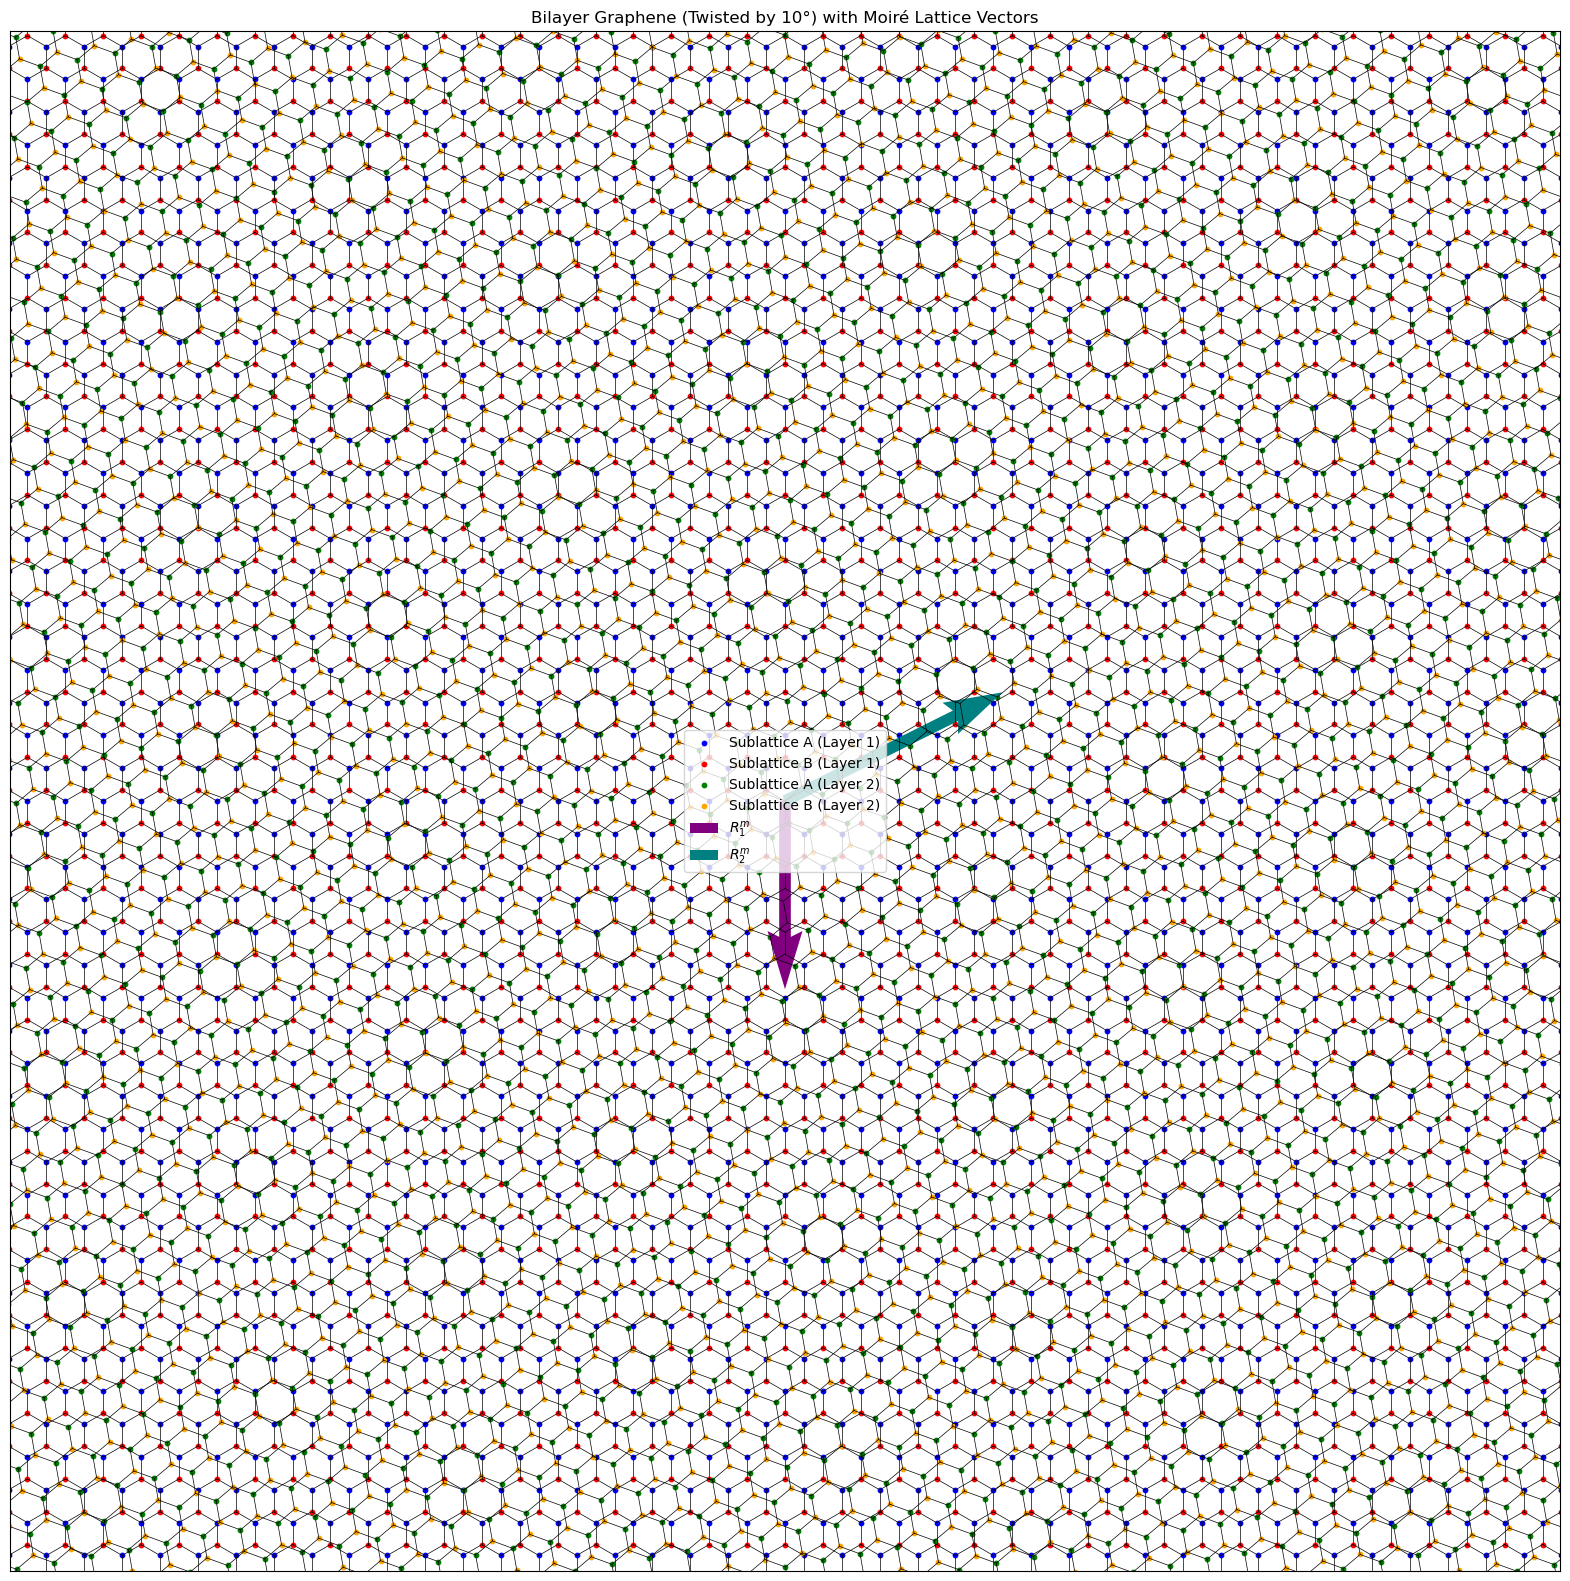

In [5]:
"""This segment finds the Moire Lattice Vectors from The Moire Reciprocal Lattice Vectors, then plots the Moire Lattice superposed on the original Lattice Layers"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from scipy.spatial import Voronoi, ConvexHull
from scipy.spatial.distance import cdist
from matplotlib import rcParams


# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return np.array([b1, b2])

def get_lattice_vectors_from_reciprocal(B):
    B = np.array(B)  # Ensure B is a NumPy array
    B_inv = np.linalg.inv(B.T / (2 * np.pi))  # Inverse of B transposed and scaled
    R1 = B_inv[:, 0]
    R2 = B_inv[:, 1]
    return np.array([R1, R2])
# Rotation matrix function
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])


# Disable LaTeX rendering to avoid errors
rcParams['text.usetex'] = False

# **Relevant Parameters**
t = 2700  # Hopping parameter (meV) (Intralayer)
w0 = 110  # AB hopping amplitude
w1 = 65   # AA hopping amplitude

# Carbon-carbon bond distance (Ångströms)
a0 = 1.42

# Lattice constant (Ångströms)
d = a0 * np.sqrt(3)

# Reciprocal lattice constant (1/Å)
kD = 4 * np.pi / (3 * a0 * np.sqrt(3))

# **Lattice Vectors**
a = np.array([
    [d, 0],
    d * np.array([0.5, np.sqrt(3)/2])
])

# **Nearest Neighbor Vectors (Corrected)**
delta1 = -(1/3) * a[0] + (2/3) * a[1]
delta2 = (-1/3) * a[0] - (1/3) * a[1]
delta3 = (2/3) * a[0] - (1/3) * a[1]
delta = np.array([delta1, delta2, delta3])

# Function to calculate reciprocal lattice vectors
def get_reciprocal_lattice_vectors(a):
    A = np.column_stack((a[0], a[1]))  # Shape: (2, 2)
    A_inv = np.linalg.inv(A)
    B = 2 * np.pi * A_inv.T  # Transpose of the inverse
    b1 = B[:, 0]
    b2 = B[:, 1]
    return b1, b2

# Rotation matrix function
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]
    ])

# Generate Lattice Points for Layer 1
def generate_lattice_points(a, n_max, m_max, scale=1.0):
    lattice_A = []
    lattice_B = []
    delta_shift = scale * (a[0] + a[1]) / 3
    for n in range(-n_max, n_max + 1):
        for m in range(-m_max, m_max + 1):
            R = scale * (n * a[0] + m * a[1])
            lattice_A.append(R)
            lattice_B.append(R + delta_shift)
    return np.array(lattice_A), np.array(lattice_B)

# Plot function for the bilayer lattice with Moiré lattice vectors
def plot_bilayer_with_moire_vectors(lattice_A1, lattice_B1, delta, a0, R1m, R2m, theta_deg, lattice_extent=20, scale=0.5):
    theta_rad = np.radians(theta_deg)
    rotation = rotation_matrix(theta_rad)
    lattice_A2 = np.dot(lattice_A1, rotation.T)
    lattice_B2 = np.dot(lattice_B1, rotation.T)
    delta_rotated = np.dot(delta, rotation.T)

    plt.figure(figsize=(20, 20))
    plt.title(f'Bilayer Graphene (Twisted by {theta_deg}°) with Moiré Lattice Vectors')
    
    # Plot sublattice A and B for layer 1
    plt.scatter(lattice_A1[:, 0], lattice_A1[:, 1], color='blue', label='Sublattice A (Layer 1)', s=10)
    plt.scatter(lattice_B1[:, 0], lattice_B1[:, 1], color='red', label='Sublattice B (Layer 1)', s=10)

    # Plot sublattice A and B for layer 2 (rotated)
    plt.scatter(lattice_A2[:, 0], lattice_A2[:, 1], color='green', label='Sublattice A (Layer 2)', s=10)
    plt.scatter(lattice_B2[:, 0], lattice_B2[:, 1], color='orange', label='Sublattice B (Layer 2)', s=10)

    # Plot bonds between nearest neighbors for both layers
    for A_pos in lattice_A1:
        for d_vec in delta:
            B_pos = A_pos - d_vec
            plt.plot([A_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], color='black', linewidth=0.5)

    for A_pos in lattice_A2:
        for d_vec in delta_rotated:
            B_pos = A_pos - d_vec
            plt.plot([A_pos[0], B_pos[0]], [A_pos[1], B_pos[1]], color='black', linewidth=0.5)

    # Plot Moiré Lattice Vectors from the origin
    origin = np.array([0, 0])
    plt.quiver(origin[0], origin[1], R1m[0], R1m[1], angles='xy', scale_units='xy', scale=1, color='purple', label='$R_1^m$')
    plt.quiver(origin[0], origin[1], R2m[0], R2m[1], angles='xy', scale_units='xy', scale=1, color='teal', label='$R_2^m$')

    # Ensure equal aspect ratio and limits for a zoomed-in portion of the lattice
    plt.axis('equal')
    plt.xlim(-lattice_extent, lattice_extent)
    plt.ylim(-lattice_extent, lattice_extent)

    plt.xticks([])
    plt.yticks([])

    # Add legend
    plt.legend()
    plt.show()


# Main function
def main():

    # **Relevant Parameters**
    t = 2700  # Hopping parameter (meV) (Intralayer)
    w0 = 110  # AB hopping amplitude
    w1 = 65   # AA hopping amplitude
    
    # Carbon-carbon bond distance (Ångströms)
    a0 = 1.42
    # Lattice constant (Ångströms)
    d = a0 * np.sqrt(3)
    
    # Reciprocal lattice constant (1/Å)
    kD = 4 * np.pi / (3 * a0 * np.sqrt(3))
    
    a0 = 1.42  # Carbon-carbon bond distance (Ångströms)
    d = a0 * np.sqrt(3)  # Lattice constant
    a = np.array([
        [d, 0],
        d * np.array([0.5, np.sqrt(3)/2])
    ])

    # Get reciprocal lattice vectors
    b = get_reciprocal_lattice_vectors(a)

    # Set rotation angles
    theta = 10 #Angle exaggerated for visualization
    theta_rad = np.radians(theta)
    theta1 = np.radians(-theta / 2)  # Rotation for layer 1
    theta2 = np.radians(theta / 2)   # Rotation for layer 2


    # Rotation of Reciprocal Lattice Vectors
    b1_rotated = np.dot(b, rotation_matrix(theta1).T)
    b2_rotated = np.dot(b, rotation_matrix(theta2).T)

    # Compute the K points from rotated reciprocal lattice vectors
    K1_plus = (2 * b1_rotated[0] + b1_rotated[1]) / 3
    K2_plus = (2 * b2_rotated[0] + b2_rotated[1]) / 3

    moire_bz_side_length = np.linalg.norm(K2_plus - K1_plus)
    expected_side_length = 2 * kD * np.sin(theta_rad / 2)

    "Moire Reciprocal Lattice Vectors"
    
    G1m = b2_rotated[0] - b1_rotated[0]
    G2m = b2_rotated[1] - b1_rotated[1]
    scale = 1 #Scale factor for visualization
    moire_lattice_vectors = get_lattice_vectors_from_reciprocal([G1m, G2m])
    R1m, R2m = scale*moire_lattice_vectors[0], scale*moire_lattice_vectors[1]


    # Output results
    print("Moiré BZ Side Length (calculated):", np.linalg.norm(K2_plus - K1_plus))
    print("Expected Side Length:", 2 * kD * np.sin(theta_rad / 2))
    print("Moiré Reciprocal Lattice Vectors G1m, G2m:\n", G1m, "\n", G2m)
    print("Moiré Lattice Vectors R1m, R2m:\n", R1m, "\n", R2m)



    
    # Generate Lattice Points for Layer 1
    n_max = 50  # Large lattice grid
    m_max = 50
    lattice_A1, lattice_B1 = generate_lattice_points(a, n_max, m_max, scale)

    scale = 0.5  #Scale factor for visualization
    R1m, R2m = moire_lattice_vectors[0], moire_lattice_vectors[1]
    plot_bilayer_with_moire_vectors(lattice_A1, lattice_B1, delta, a0, R1m, R2m, theta, lattice_extent=50, scale=scale)
    


main()
